In [1]:
#%pip install scikit-learn

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [4]:
df = getTickerData('btc-usd', '729d', '1h')
df = df.drop(columns={'Volume', 'Adj Close', 'Open', 'High', 'Low'})
df = df.rename(columns={'Close': 'close', 'Datetime': 'date', 'Date': 'date'})
#df['date'] = pd.to_datetime(df['date'])
df.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17237 entries, 0 to 17236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    17237 non-null  datetime64[ns, UTC]
 1   close   17237 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 269.5 KB


In [5]:
test = talib.EMA(df['close'])
df['ema'] = test
df = df.dropna()

In [6]:
rn = random.randint(0, df.value_counts().sum()) 
i = 0

35990.04296875


,date,close,ema
6287,2022-01-28 01:00:00+00:00,36923.300781,36664.882941
6288,2022-01-28 02:00:00+00:00,36964.808594,36684.232983
6289,2022-01-28 03:00:00+00:00,37336.136719,36726.291289
6290,2022-01-28 04:00:00+00:00,37181.886719,36755.684542
6291,2022-01-28 05:00:00+00:00,37219.375000,36785.600056


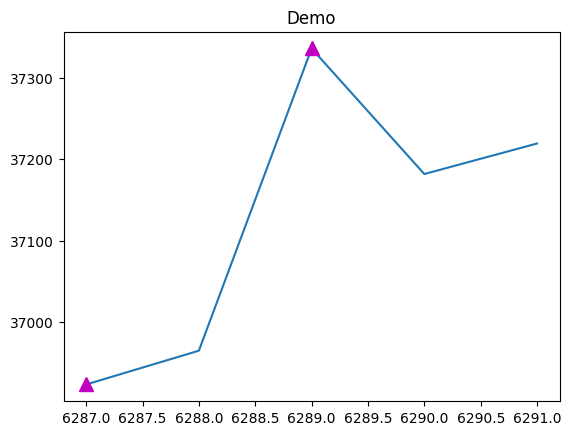

In [7]:
df2 = df.iloc[rn+i:rn+5+i,:]
final_value = df.loc[rn+5+i]['close']
close_value = df.loc[rn+4+i]['close']
plt.plot(df2['close'])
plt.plot(df2['close'], '^', markersize=10, color='m', label = 'buying signal', markevery = [True, False, True, False, False])
plt.title('Demo')
print(final_value)
i+=1
df2

In [8]:
ratio = 20534.63281 / 19985.230469	
ratio2 = 20010.623047 / 20259.931641

trade_fee_bid_percent = 0.01  # unit
trade_fee_ask_percent = 0.005  # unit

cost = np.log((1 - trade_fee_ask_percent) * (1 - trade_fee_bid_percent))
print(cost)

print(ratio)
print(np.log(ratio))

-0.015062877677045743
1.0274904180791011
0.027119341874308964


In [9]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2

In [68]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()        
        self.df = df.drop(columns={'date'})
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(len(Positions))
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.needed_space = self.window_size + self.n_steps
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        
        self.long_pos = []
        self.short_pos = []
        self.hold_pos = []
        self.current_pos = None
        self.held_price = 0
        self.in_a_pos = False
        
    def step(self, action):
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
            
        reward = self.calculate_reward(action)
            
        if action == Positions.SHORT:
            self.short_pos.append(True)
            self.long_pos.append(False)
            self.hold_pos.append(False)
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
        elif action == Positions.LONG:
            self.short_pos.append(False)
            self.long_pos.append(True)
            self.hold_pos.append(False)
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
        else:
            self.short_pos.append(False)
            self.long_pos.append(False)
            self.hold_pos.append(True)      
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
        
        observation = self.get_observation()
        info = {}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        self.done = False
        self.current_step = 0
        self.long_pos.clear()
        self.short_pos.clear()
        self.hold_pos.clear()
        next_observation = self.get_observation(is_random=True)
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        self.held_price = 0
        self.in_a_pos = False
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def final_render(self):
        final_observation = self.df.iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+self.n_steps]['close']
        win_rate = sum(n == 1 for n in self.long_pos) / self.n_steps
        loss_rate = 1 - win_rate
        
        self.short_pos.append(False)
        self.long_pos.append(False)
        self.hold_pos.append(False)
        plt.figure(figsize=(20,7))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = self.long_pos)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = self.short_pos)
        plt.plot(final_observation, 'o', markersize=10, color='b', label = 'Holding signal', markevery = self.hold_pos)
        plt.xticks([])
        plt.title("Final result of the last trading session")
        plt.ylabel('Close price')
        plt.legend()
        plt.show()
        
        return win_rate, loss_rate
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [69]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
    
    def calculate_reward(self, action):
        reward = -0.000000001
        
        if action != Positions.HOLD and self.in_a_pos:
            ratio = self.final_value / self.held_price
            
            if self.current_pos == Positions.SHORT: 
                if self.final_value < self.held_price:
                    reward = -np.log(ratio)
                    
            if self.current_pos == Positions.LONG:
                if self.final_value > self.held_price:
                    reward = np.log(ratio)
        return reward

In [70]:
env = Trading(df, window_size=90, n_steps=100)

In [71]:
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


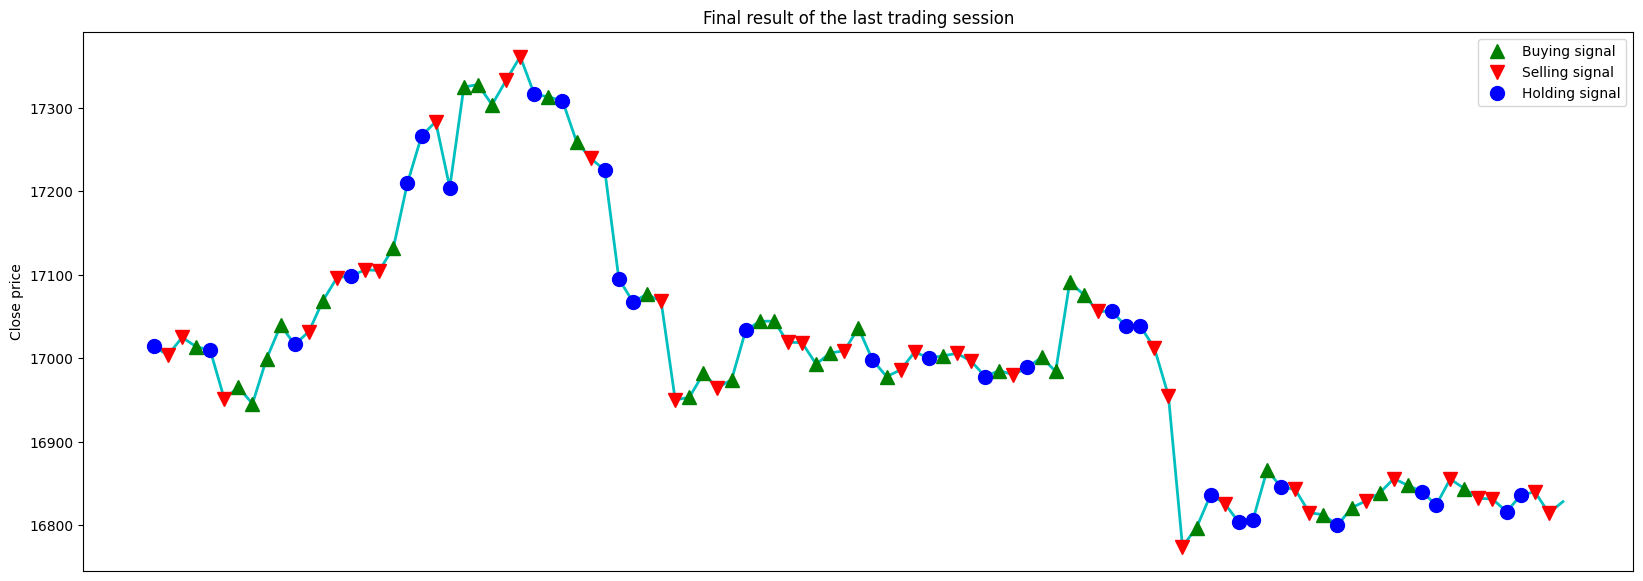

episode - 1 || score - 0.0798057684466632


In [72]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
    win_rate, loss_rate = env.final_render()
    print(f'episode - {n} || score - {score}')

In [15]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [16]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [17]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [18]:
model.learn(total_timesteps=50000, callback=callback)

Logging to ./logs/RecurrentPPO_8


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0.0259   |
| time/              |          |
|    fps             | 97       |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 128      |
---------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0231        |
| time/                   |               |
|    fps                  | 93            |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 0.00020008814 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 0.167         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.0178        |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000827     |
|    value_loss           | 0.106         |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.035         |
| time/                   |               |
|    fps                  | 100           |
|    iterations           | 3             |
|    time_elapsed         | 3             |
|    total_timesteps      | 384           |
| train/                  |               |
|    approx_kl            | 1.9858591e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -0.152        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.0111        |
|    n_updates            | 20            |
|    policy_gradient_loss | 0.000168      |
|    value_loss           | 0.0196        |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.031         |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 4             |
|    time_elapsed         | 4             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00014189724 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -6.88         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00108      |
|    n_updates            | 30            |
|    policy_gradient_loss | -0.00087      |
|    value_loss           | 0.00294       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0306        |
| time/                   |               |
|    fps                  | 104           |
|    iterations           | 5             |
|    time_elapsed         | 6             |
|    total_timesteps      | 640           |
| train/                  |               |
|    approx_kl            | 0.00010276167 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -4.6          |
|    learning_rate        | 0.0001        |
|    loss                 | 8.08e-05      |
|    n_updates            | 40            |
|    policy_gradient_loss | -6.75e-05     |
|    value_loss           | 0.000838      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0309        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 6             |
|    time_elapsed         | 7             |
|    total_timesteps      | 768           |
| train/                  |               |
|    approx_kl            | 0.00014103577 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -4.72         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000891     |
|    n_updates            | 50            |
|    policy_gradient_loss | -0.000535     |
|    value_loss           | 0.000972      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0335        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 7             |
|    time_elapsed         | 8             |
|    total_timesteps      | 896           |
| train/                  |               |
|    approx_kl            | 3.5460573e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -7.16         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00154       |
|    n_updates            | 60            |
|    policy_gradient_loss | 0.000381      |
|    value_loss           | 0.00931       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.033         |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 8             |
|    time_elapsed         | 9             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 0.00012638839 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -10.2         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000351      |
|    n_updates            | 70            |
|    policy_gradient_loss | -0.000851     |
|    value_loss           | 0.00649       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0329        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 9             |
|    time_elapsed         | 10            |
|    total_timesteps      | 1152          |
| train/                  |               |
|    approx_kl            | 3.9815903e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -4.24         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000398      |
|    n_updates            | 80            |
|    policy_gradient_loss | 0.000184      |
|    value_loss           | 0.000894      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0317        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 10            |
|    time_elapsed         | 11            |
|    total_timesteps      | 1280          |
| train/                  |               |
|    approx_kl            | 0.00016422244 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -3.68         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00189      |
|    n_updates            | 90            |
|    policy_gradient_loss | -0.00096      |
|    value_loss           | 0.000756      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0315        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 11            |
|    time_elapsed         | 12            |
|    total_timesteps      | 1408          |
| train/                  |               |
|    approx_kl            | 9.6859876e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -5.84         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00157      |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.000526     |
|    value_loss           | 0.000589      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0313        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 12            |
|    time_elapsed         | 14            |
|    total_timesteps      | 1536          |
| train/                  |               |
|    approx_kl            | 0.00032002898 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -4.57         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0032       |
|    n_updates            | 110           |
|    policy_gradient_loss | -0.00166      |
|    value_loss           | 0.000698      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0317        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 13            |
|    time_elapsed         | 15            |
|    total_timesteps      | 1664          |
| train/                  |               |
|    approx_kl            | 0.00045781815 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -1.79         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00298      |
|    n_updates            | 120           |
|    policy_gradient_loss | -0.0015       |
|    value_loss           | 0.00065       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0331        |
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 14            |
|    time_elapsed         | 16            |
|    total_timesteps      | 1792          |
| train/                  |               |
|    approx_kl            | 7.9878606e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.09         |
|    explained_variance   | -1.87         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000491      |
|    n_updates            | 130           |
|    policy_gradient_loss | 0.000399      |
|    value_loss           | 0.000712      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0328       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 15           |
|    time_elapsed         | 17           |
|    total_timesteps      | 1920         |
| train/                  |              |
|    approx_kl            | 0.0004506763 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -1.28        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00579     |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00292     |
|    value_loss           | 0.00132      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.033        |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 16           |
|    time_elapsed         | 18           |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 9.021303e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -1.28        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000878     |
|    n_updates            | 150          |
|    policy_gradient_loss | 0.000728     |
|    value_loss           | 0.000613     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0332       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 17           |
|    time_elapsed         | 19           |
|    total_timesteps      | 2176         |
| train/                  |              |
|    approx_kl            | 0.0001271721 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -0.909       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00127     |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.000718    |
|    value_loss           | 0.000728     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0322        |
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 18            |
|    time_elapsed         | 20            |
|    total_timesteps      | 2304          |
| train/                  |               |
|    approx_kl            | 1.9482803e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -0.9          |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00017      |
|    n_updates            | 170           |
|    policy_gradient_loss | 7.97e-05      |
|    value_loss           | 0.000534      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0325        |
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 19            |
|    time_elapsed         | 21            |
|    total_timesteps      | 2432          |
| train/                  |               |
|    approx_kl            | 3.1766947e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -3.82         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000342      |
|    n_updates            | 180           |
|    policy_gradient_loss | -5.59e-07     |
|    value_loss           | 0.000846      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0334       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 20           |
|    time_elapsed         | 23           |
|    total_timesteps      | 2560         |
| train/                  |              |
|    approx_kl            | 6.693648e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -0.464       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000976    |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.000591    |
|    value_loss           | 0.000779     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0354        |
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 21            |
|    time_elapsed         | 24            |
|    total_timesteps      | 2688          |
| train/                  |               |
|    approx_kl            | 0.00015417486 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -2            |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00134      |
|    n_updates            | 200           |
|    policy_gradient_loss | -0.000741     |
|    value_loss           | 0.000767      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0363       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 22           |
|    time_elapsed         | 25           |
|    total_timesteps      | 2816         |
| train/                  |              |
|    approx_kl            | 0.0002203281 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | -0.313       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000247    |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.000491    |
|    value_loss           | 0.00154      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0361       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 23           |
|    time_elapsed         | 26           |
|    total_timesteps      | 2944         |
| train/                  |              |
|    approx_kl            | 0.0005491609 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | -0.207       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00391     |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.0019      |
|    value_loss           | 0.000887     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0355       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 24           |
|    time_elapsed         | 27           |
|    total_timesteps      | 3072         |
| train/                  |              |
|    approx_kl            | 0.0012594457 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | -1.04        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00832     |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00396     |
|    value_loss           | 0.000574     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0361       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 25           |
|    time_elapsed         | 28           |
|    total_timesteps      | 3200         |
| train/                  |              |
|    approx_kl            | 0.0017543924 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.07        |
|    explained_variance   | -1.41        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0037      |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00201     |
|    value_loss           | 0.000611     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0366        |
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 26            |
|    time_elapsed         | 30            |
|    total_timesteps      | 3328          |
| train/                  |               |
|    approx_kl            | 0.00036495412 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.06         |
|    explained_variance   | -0.61         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00102       |
|    n_updates            | 250           |
|    policy_gradient_loss | 0.000194      |
|    value_loss           | 0.00102       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.036         |
| time/                   |               |
|    fps                  | 111           |
|    iterations           | 27            |
|    time_elapsed         | 31            |
|    total_timesteps      | 3456          |
| train/                  |               |
|    approx_kl            | 0.00023813033 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.05         |
|    explained_variance   | -1.18         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000734     |
|    n_updates            | 260           |
|    policy_gradient_loss | -0.000511     |
|    value_loss           | 0.000805      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0367       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 28           |
|    time_elapsed         | 32           |
|    total_timesteps      | 3584         |
| train/                  |              |
|    approx_kl            | 0.0019303476 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.04        |
|    explained_variance   | -0.805       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00784     |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.00357     |
|    value_loss           | 0.000673     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0356       |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 29           |
|    time_elapsed         | 33           |
|    total_timesteps      | 3712         |
| train/                  |              |
|    approx_kl            | 0.0008259425 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | -0.585       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000919     |
|    n_updates            | 280          |
|    policy_gradient_loss | 0.000524     |
|    value_loss           | 0.000764     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.034         |
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 30            |
|    time_elapsed         | 34            |
|    total_timesteps      | 3840          |
| train/                  |               |
|    approx_kl            | 0.00020193122 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.01         |
|    explained_variance   | -1.42         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00126      |
|    n_updates            | 290           |
|    policy_gradient_loss | -0.000348     |
|    value_loss           | 0.000292      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.035        |
| time/                   |              |
|    fps                  | 110          |
|    iterations           | 31           |
|    time_elapsed         | 36           |
|    total_timesteps      | 3968         |
| train/                  |              |
|    approx_kl            | 0.0009062849 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | -1.55        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0029      |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00136     |
|    value_loss           | 0.000253     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0355        |
| time/                   |               |
|    fps                  | 110           |
|    iterations           | 32            |
|    time_elapsed         | 37            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00013118424 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.03         |
|    explained_variance   | -0.232        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0016       |
|    n_updates            | 310           |
|    policy_gradient_loss | -0.000143     |
|    value_loss           | 0.000951      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0355       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 33           |
|    time_elapsed         | 38           |
|    total_timesteps      | 4224         |
| train/                  |              |
|    approx_kl            | 0.0013361978 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | -0.91        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00307     |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 0.000242     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0359        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 34            |
|    time_elapsed         | 39            |
|    total_timesteps      | 4352          |
| train/                  |               |
|    approx_kl            | 0.00020512566 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1            |
|    explained_variance   | -1.12         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00127      |
|    n_updates            | 330           |
|    policy_gradient_loss | -8.8e-05      |
|    value_loss           | 0.000203      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0355       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 35           |
|    time_elapsed         | 40           |
|    total_timesteps      | 4480         |
| train/                  |              |
|    approx_kl            | 4.069088e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1           |
|    explained_variance   | -0.495       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00102     |
|    n_updates            | 340          |
|    policy_gradient_loss | 0.000132     |
|    value_loss           | 0.000276     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0336        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 36            |
|    time_elapsed         | 42            |
|    total_timesteps      | 4608          |
| train/                  |               |
|    approx_kl            | 0.00029686792 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.01         |
|    explained_variance   | -0.175        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.003        |
|    n_updates            | 350           |
|    policy_gradient_loss | -0.000702     |
|    value_loss           | 0.000504      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0332       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 37           |
|    time_elapsed         | 43           |
|    total_timesteps      | 4736         |
| train/                  |              |
|    approx_kl            | 0.0012863297 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | -0.445       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0041      |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00212     |
|    value_loss           | 0.000291     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0324        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 38            |
|    time_elapsed         | 44            |
|    total_timesteps      | 4864          |
| train/                  |               |
|    approx_kl            | 0.00051971246 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.04         |
|    explained_variance   | -0.196        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00137      |
|    n_updates            | 370           |
|    policy_gradient_loss | -0.000541     |
|    value_loss           | 0.000468      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0323       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 39           |
|    time_elapsed         | 45           |
|    total_timesteps      | 4992         |
| train/                  |              |
|    approx_kl            | 0.0001252857 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.04        |
|    explained_variance   | -0.381       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00236     |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.000269    |
|    value_loss           | 0.000252     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0335        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 40            |
|    time_elapsed         | 46            |
|    total_timesteps      | 5120          |
| train/                  |               |
|    approx_kl            | 0.00019051973 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.04         |
|    explained_variance   | -0.298        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000622      |
|    n_updates            | 390           |
|    policy_gradient_loss | 0.000334      |
|    value_loss           | 0.000243      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0339        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 41            |
|    time_elapsed         | 48            |
|    total_timesteps      | 5248          |
| train/                  |               |
|    approx_kl            | 0.00036549522 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.03         |
|    explained_variance   | -0.104        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00518      |
|    n_updates            | 400           |
|    policy_gradient_loss | -0.00197      |
|    value_loss           | 0.000398      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0347       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 42           |
|    time_elapsed         | 49           |
|    total_timesteps      | 5376         |
| train/                  |              |
|    approx_kl            | 0.0005301754 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | -0.125       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000266    |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.000196    |
|    value_loss           | 0.000273     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0335       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 43           |
|    time_elapsed         | 50           |
|    total_timesteps      | 5504         |
| train/                  |              |
|    approx_kl            | 0.0013250154 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | -0.134       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0106      |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00474     |
|    value_loss           | 0.000219     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0345       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 44           |
|    time_elapsed         | 51           |
|    total_timesteps      | 5632         |
| train/                  |              |
|    approx_kl            | 0.0026301043 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.977       |
|    explained_variance   | -0.226       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00856     |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00416     |
|    value_loss           | 0.000184     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0351       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 45           |
|    time_elapsed         | 52           |
|    total_timesteps      | 5760         |
| train/                  |              |
|    approx_kl            | 0.0018410026 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.945       |
|    explained_variance   | -0.105       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00329     |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 0.000188     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0362        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 46            |
|    time_elapsed         | 53            |
|    total_timesteps      | 5888          |
| train/                  |               |
|    approx_kl            | 1.1599623e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.933        |
|    explained_variance   | -0.0911       |
|    learning_rate        | 0.0001        |
|    loss                 | 9.46e-05      |
|    n_updates            | 450           |
|    policy_gradient_loss | 0.000847      |
|    value_loss           | 0.000222      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0349        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 47            |
|    time_elapsed         | 54            |
|    total_timesteps      | 6016          |
| train/                  |               |
|    approx_kl            | 0.00016136793 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.939        |
|    explained_variance   | -0.0712       |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00026       |
|    n_updates            | 460           |
|    policy_gradient_loss | 6.56e-05      |
|    value_loss           | 0.000314      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0359       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 48           |
|    time_elapsed         | 56           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 8.930266e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.945       |
|    explained_variance   | -0.0917      |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000689    |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.000293    |
|    value_loss           | 0.000155     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0361        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 49            |
|    time_elapsed         | 57            |
|    total_timesteps      | 6272          |
| train/                  |               |
|    approx_kl            | 0.00015083281 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.955        |
|    explained_variance   | -0.0617       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.001        |
|    n_updates            | 480           |
|    policy_gradient_loss | -0.00033      |
|    value_loss           | 0.000251      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0352       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 50           |
|    time_elapsed         | 58           |
|    total_timesteps      | 6400         |
| train/                  |              |
|    approx_kl            | 9.978982e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.959       |
|    explained_variance   | -0.0507      |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000195     |
|    n_updates            | 490          |
|    policy_gradient_loss | 7.83e-05     |
|    value_loss           | 0.000148     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0352        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 51            |
|    time_elapsed         | 59            |
|    total_timesteps      | 6528          |
| train/                  |               |
|    approx_kl            | 3.7748367e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.96         |
|    explained_variance   | -0.03         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000142     |
|    n_updates            | 500           |
|    policy_gradient_loss | -0.00011      |
|    value_loss           | 0.000202      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.036        |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 52           |
|    time_elapsed         | 60           |
|    total_timesteps      | 6656         |
| train/                  |              |
|    approx_kl            | 0.0003051604 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.958       |
|    explained_variance   | -0.0175      |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00381     |
|    n_updates            | 510          |
|    policy_gradient_loss | -0.00163     |
|    value_loss           | 0.000156     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0359      |
| time/                   |             |
|    fps                  | 109         |
|    iterations           | 53          |
|    time_elapsed         | 62          |
|    total_timesteps      | 6784        |
| train/                  |             |
|    approx_kl            | 0.000601911 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.947      |
|    explained_variance   | 0.17        |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00338    |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00177    |
|    value_loss           | 0.000922    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0367        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 54            |
|    time_elapsed         | 63            |
|    total_timesteps      | 6912          |
| train/                  |               |
|    approx_kl            | 0.00079096435 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.95         |
|    explained_variance   | -0.0997       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00528      |
|    n_updates            | 530           |
|    policy_gradient_loss | -0.0017       |
|    value_loss           | 0.0009        |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0357       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 55           |
|    time_elapsed         | 64           |
|    total_timesteps      | 7040         |
| train/                  |              |
|    approx_kl            | 0.0012644734 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.973       |
|    explained_variance   | -0.223       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00463     |
|    n_updates            | 540          |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 0.000362     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 20             |
|    ep_rew_mean          | 0.0374         |
| time/                   |                |
|    fps                  | 109            |
|    iterations           | 56             |
|    time_elapsed         | 65             |
|    total_timesteps      | 7168           |
| train/                  |                |
|    approx_kl            | 0.000113527756 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.985         |
|    explained_variance   | -0.211         |
|    learning_rate        | 0.0001         |
|    loss                 | 8.02e-05       |
|    n_updates            | 550            |
|    policy_gradient_loss | 0.000861       |
|    value_loss           | 0.000211       |
--------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0374        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 57            |
|    time_elapsed         | 66            |
|    total_timesteps      | 7296          |
| train/                  |               |
|    approx_kl            | 0.00082084304 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.985        |
|    explained_variance   | -0.143        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0109       |
|    n_updates            | 560           |
|    policy_gradient_loss | -0.00472      |
|    value_loss           | 0.00041       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0388        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 58            |
|    time_elapsed         | 67            |
|    total_timesteps      | 7424          |
| train/                  |               |
|    approx_kl            | 0.00028361566 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.972        |
|    explained_variance   | -0.124        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00122       |
|    n_updates            | 570           |
|    policy_gradient_loss | 0.00074       |
|    value_loss           | 0.000303      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0389        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 59            |
|    time_elapsed         | 69            |
|    total_timesteps      | 7552          |
| train/                  |               |
|    approx_kl            | 0.00010882132 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.968        |
|    explained_variance   | -0.186        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00124      |
|    n_updates            | 580           |
|    policy_gradient_loss | -0.000566     |
|    value_loss           | 0.000233      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0386        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 60            |
|    time_elapsed         | 70            |
|    total_timesteps      | 7680          |
| train/                  |               |
|    approx_kl            | 4.0793326e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.967        |
|    explained_variance   | -0.123        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000648     |
|    n_updates            | 590           |
|    policy_gradient_loss | 3.05e-05      |
|    value_loss           | 0.000168      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0384        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 61            |
|    time_elapsed         | 71            |
|    total_timesteps      | 7808          |
| train/                  |               |
|    approx_kl            | 0.00018479303 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.961        |
|    explained_variance   | -0.0734       |
|    learning_rate        | 0.0001        |
|    loss                 | -3.82e-05     |
|    n_updates            | 600           |
|    policy_gradient_loss | -1.27e-05     |
|    value_loss           | 0.000209      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0375       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 62           |
|    time_elapsed         | 72           |
|    total_timesteps      | 7936         |
| train/                  |              |
|    approx_kl            | 0.0005655824 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.948       |
|    explained_variance   | -0.0775      |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00371     |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.00169     |
|    value_loss           | 0.000168     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0366       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 63           |
|    time_elapsed         | 73           |
|    total_timesteps      | 8064         |
| train/                  |              |
|    approx_kl            | 0.0013174568 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.923       |
|    explained_variance   | -0.059       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00361     |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.00182     |
|    value_loss           | 0.000133     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0381       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 64           |
|    time_elapsed         | 74           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0006252853 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.897       |
|    explained_variance   | -0.0577      |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00031     |
|    n_updates            | 630          |
|    policy_gradient_loss | -0.000189    |
|    value_loss           | 0.000102     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0373        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 65            |
|    time_elapsed         | 76            |
|    total_timesteps      | 8320          |
| train/                  |               |
|    approx_kl            | 0.00013514701 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.886        |
|    explained_variance   | -0.885        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00289      |
|    n_updates            | 640           |
|    policy_gradient_loss | -0.00107      |
|    value_loss           | 0.00125       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0377        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 66            |
|    time_elapsed         | 77            |
|    total_timesteps      | 8448          |
| train/                  |               |
|    approx_kl            | 0.00022621639 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.886        |
|    explained_variance   | -0.0437       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000213     |
|    n_updates            | 650           |
|    policy_gradient_loss | -3.9e-05      |
|    value_loss           | 0.000169      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0383        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 67            |
|    time_elapsed         | 78            |
|    total_timesteps      | 8576          |
| train/                  |               |
|    approx_kl            | 0.00010121055 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.879        |
|    explained_variance   | -0.0104       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000395     |
|    n_updates            | 660           |
|    policy_gradient_loss | -0.000211     |
|    value_loss           | 0.000134      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0362        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 68            |
|    time_elapsed         | 79            |
|    total_timesteps      | 8704          |
| train/                  |               |
|    approx_kl            | 0.00027006026 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.873        |
|    explained_variance   | 0.00421       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00261      |
|    n_updates            | 670           |
|    policy_gradient_loss | -0.000844     |
|    value_loss           | 0.000214      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0369        |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 69            |
|    time_elapsed         | 80            |
|    total_timesteps      | 8832          |
| train/                  |               |
|    approx_kl            | 0.00034183916 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.864        |
|    explained_variance   | 0.0128        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.001        |
|    n_updates            | 680           |
|    policy_gradient_loss | -0.000454     |
|    value_loss           | 9.56e-05      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.036         |
| time/                   |               |
|    fps                  | 109           |
|    iterations           | 70            |
|    time_elapsed         | 82            |
|    total_timesteps      | 8960          |
| train/                  |               |
|    approx_kl            | 0.00035891868 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.871        |
|    explained_variance   | 0.0133        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00278      |
|    n_updates            | 690           |
|    policy_gradient_loss | -0.000855     |
|    value_loss           | 0.000196      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0371       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 71           |
|    time_elapsed         | 83           |
|    total_timesteps      | 9088         |
| train/                  |              |
|    approx_kl            | 0.0013657878 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.89        |
|    explained_variance   | 0.0217       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00669     |
|    n_updates            | 700          |
|    policy_gradient_loss | -0.00315     |
|    value_loss           | 0.0001       |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0368       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 72           |
|    time_elapsed         | 84           |
|    total_timesteps      | 9216         |
| train/                  |              |
|    approx_kl            | 0.0008073719 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.901       |
|    explained_variance   | 0.0136       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0017      |
|    n_updates            | 710          |
|    policy_gradient_loss | -0.000949    |
|    value_loss           | 0.000416     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0359       |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 73           |
|    time_elapsed         | 85           |
|    total_timesteps      | 9344         |
| train/                  |              |
|    approx_kl            | 0.0011290624 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.903       |
|    explained_variance   | 0.0113       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00604     |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.00296     |
|    value_loss           | 0.000809     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0353       |
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 74           |
|    time_elapsed         | 86           |
|    total_timesteps      | 9472         |
| train/                  |              |
|    approx_kl            | 0.0005232296 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.909       |
|    explained_variance   | 0.0227       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000727     |
|    n_updates            | 730          |
|    policy_gradient_loss | 0.000362     |
|    value_loss           | 0.000257     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0369        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 75            |
|    time_elapsed         | 88            |
|    total_timesteps      | 9600          |
| train/                  |               |
|    approx_kl            | 0.00027828338 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.909        |
|    explained_variance   | 0.0144        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00379      |
|    n_updates            | 740           |
|    policy_gradient_loss | -0.00131      |
|    value_loss           | 0.000421      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0364        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 76            |
|    time_elapsed         | 89            |
|    total_timesteps      | 9728          |
| train/                  |               |
|    approx_kl            | 0.00055979704 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.895        |
|    explained_variance   | 0.0311        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000479     |
|    n_updates            | 750           |
|    policy_gradient_loss | -0.000302     |
|    value_loss           | 0.000234      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0377        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 77            |
|    time_elapsed         | 90            |
|    total_timesteps      | 9856          |
| train/                  |               |
|    approx_kl            | 0.00058095343 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.882        |
|    explained_variance   | 0.0696        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00297      |
|    n_updates            | 760           |
|    policy_gradient_loss | -0.00126      |
|    value_loss           | 0.000152      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0398       |
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 78           |
|    time_elapsed         | 91           |
|    total_timesteps      | 9984         |
| train/                  |              |
|    approx_kl            | 0.0010744175 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.871       |
|    explained_variance   | 0.0308       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00307     |
|    n_updates            | 770          |
|    policy_gradient_loss | -0.00169     |
|    value_loss           | 0.000797     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0385       |
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 79           |
|    time_elapsed         | 93           |
|    total_timesteps      | 10112        |
| train/                  |              |
|    approx_kl            | 0.0014679274 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.849       |
|    explained_variance   | 0.071        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00452     |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00225     |
|    value_loss           | 0.00011      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0392       |
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 80           |
|    time_elapsed         | 94           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0016816873 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.817       |
|    explained_variance   | 0.54         |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00499     |
|    n_updates            | 790          |
|    policy_gradient_loss | -0.0025      |
|    value_loss           | 0.000235     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0406        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 81            |
|    time_elapsed         | 95            |
|    total_timesteps      | 10368         |
| train/                  |               |
|    approx_kl            | 0.00083900103 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.782        |
|    explained_variance   | -0.202        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000591     |
|    n_updates            | 800           |
|    policy_gradient_loss | -0.000442     |
|    value_loss           | 0.000302      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0403        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 82            |
|    time_elapsed         | 97            |
|    total_timesteps      | 10496         |
| train/                  |               |
|    approx_kl            | 3.1025615e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.764        |
|    explained_variance   | 0.0253        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000572     |
|    n_updates            | 810           |
|    policy_gradient_loss | -0.000213     |
|    value_loss           | 0.000475      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0404       |
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 83           |
|    time_elapsed         | 98           |
|    total_timesteps      | 10624        |
| train/                  |              |
|    approx_kl            | 0.0008373223 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.773       |
|    explained_variance   | 0.0877       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00515     |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00232     |
|    value_loss           | 0.000124     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0401        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 84            |
|    time_elapsed         | 99            |
|    total_timesteps      | 10752         |
| train/                  |               |
|    approx_kl            | 0.00032169977 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.796        |
|    explained_variance   | 0.0126        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000184      |
|    n_updates            | 830           |
|    policy_gradient_loss | 0.000409      |
|    value_loss           | 0.000448      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0398       |
| time/                   |              |
|    fps                  | 108          |
|    iterations           | 85           |
|    time_elapsed         | 100          |
|    total_timesteps      | 10880        |
| train/                  |              |
|    approx_kl            | 0.0005225348 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.813       |
|    explained_variance   | 0.0588       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.005       |
|    n_updates            | 840          |
|    policy_gradient_loss | -0.00204     |
|    value_loss           | 0.000178     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0398        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 86            |
|    time_elapsed         | 101           |
|    total_timesteps      | 11008         |
| train/                  |               |
|    approx_kl            | 0.00036985613 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.838        |
|    explained_variance   | 0.0951        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000612      |
|    n_updates            | 850           |
|    policy_gradient_loss | 0.000359      |
|    value_loss           | 0.000113      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0381        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 87            |
|    time_elapsed         | 102           |
|    total_timesteps      | 11136         |
| train/                  |               |
|    approx_kl            | 5.5305194e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.845        |
|    explained_variance   | 0.0757        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000979     |
|    n_updates            | 860           |
|    policy_gradient_loss | -0.000326     |
|    value_loss           | 9.7e-05       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0367        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 88            |
|    time_elapsed         | 104           |
|    total_timesteps      | 11264         |
| train/                  |               |
|    approx_kl            | 0.00021885149 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.838        |
|    explained_variance   | 0.0527        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00113      |
|    n_updates            | 870           |
|    policy_gradient_loss | -0.000405     |
|    value_loss           | 0.00013       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0371        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 89            |
|    time_elapsed         | 105           |
|    total_timesteps      | 11392         |
| train/                  |               |
|    approx_kl            | 1.0895543e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.826        |
|    explained_variance   | 0.0208        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000161      |
|    n_updates            | 880           |
|    policy_gradient_loss | 0.000218      |
|    value_loss           | 0.000504      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0367        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 90            |
|    time_elapsed         | 106           |
|    total_timesteps      | 11520         |
| train/                  |               |
|    approx_kl            | 0.00017420249 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.824        |
|    explained_variance   | 0.102         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00348      |
|    n_updates            | 890           |
|    policy_gradient_loss | -0.000977     |
|    value_loss           | 0.00012       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0381        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 91            |
|    time_elapsed         | 107           |
|    total_timesteps      | 11648         |
| train/                  |               |
|    approx_kl            | 0.00060172053 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.805        |
|    explained_variance   | 0.0697        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00166      |
|    n_updates            | 900           |
|    policy_gradient_loss | -0.000714     |
|    value_loss           | 0.000157      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0379        |
| time/                   |               |
|    fps                  | 108           |
|    iterations           | 92            |
|    time_elapsed         | 108           |
|    total_timesteps      | 11776         |
| train/                  |               |
|    approx_kl            | 0.00079069147 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.789        |
|    explained_variance   | -0.0849       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00268      |
|    n_updates            | 910           |
|    policy_gradient_loss | -0.00123      |
|    value_loss           | 0.000643      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.036        |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 93           |
|    time_elapsed         | 110          |
|    total_timesteps      | 11904        |
| train/                  |              |
|    approx_kl            | 0.0018375679 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.757       |
|    explained_variance   | 0.0547       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0106      |
|    n_updates            | 920          |
|    policy_gradient_loss | -0.00514     |
|    value_loss           | 0.000273     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0364        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 94            |
|    time_elapsed         | 111           |
|    total_timesteps      | 12032         |
| train/                  |               |
|    approx_kl            | 0.00024633016 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.724        |
|    explained_variance   | 0.0892        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00125       |
|    n_updates            | 930           |
|    policy_gradient_loss | 0.000987      |
|    value_loss           | 0.000127      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0367       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 95           |
|    time_elapsed         | 112          |
|    total_timesteps      | 12160        |
| train/                  |              |
|    approx_kl            | 0.0001468081 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.72        |
|    explained_variance   | 0.0274       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00167     |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.000811    |
|    value_loss           | 0.000187     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0359        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 96            |
|    time_elapsed         | 113           |
|    total_timesteps      | 12288         |
| train/                  |               |
|    approx_kl            | 0.00025168387 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.721        |
|    explained_variance   | 0.0766        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00122      |
|    n_updates            | 950           |
|    policy_gradient_loss | -0.000645     |
|    value_loss           | 0.000223      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0361       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 97           |
|    time_elapsed         | 115          |
|    total_timesteps      | 12416        |
| train/                  |              |
|    approx_kl            | 0.0009635058 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.733       |
|    explained_variance   | 0.0703       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00898     |
|    n_updates            | 960          |
|    policy_gradient_loss | -0.00405     |
|    value_loss           | 0.000133     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0366       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 98           |
|    time_elapsed         | 116          |
|    total_timesteps      | 12544        |
| train/                  |              |
|    approx_kl            | 0.0020950139 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.762       |
|    explained_variance   | 0.0557       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00623     |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00309     |
|    value_loss           | 0.000184     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.036        |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 99           |
|    time_elapsed         | 117          |
|    total_timesteps      | 12672        |
| train/                  |              |
|    approx_kl            | 0.0013532159 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.791       |
|    explained_variance   | 0.0313       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00196     |
|    n_updates            | 980          |
|    policy_gradient_loss | -0.00112     |
|    value_loss           | 0.00044      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0374        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 100           |
|    time_elapsed         | 118           |
|    total_timesteps      | 12800         |
| train/                  |               |
|    approx_kl            | 0.00017577782 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.802        |
|    explained_variance   | 0.0484        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000903     |
|    n_updates            | 990           |
|    policy_gradient_loss | -0.000324     |
|    value_loss           | 0.000186      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0384        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 101           |
|    time_elapsed         | 120           |
|    total_timesteps      | 12928         |
| train/                  |               |
|    approx_kl            | 0.00043777283 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.801        |
|    explained_variance   | 0.0463        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00508      |
|    n_updates            | 1000          |
|    policy_gradient_loss | -0.0018       |
|    value_loss           | 0.000253      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0389        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 102           |
|    time_elapsed         | 121           |
|    total_timesteps      | 13056         |
| train/                  |               |
|    approx_kl            | 0.00043464918 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.813        |
|    explained_variance   | 0.116         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000198      |
|    n_updates            | 1010          |
|    policy_gradient_loss | 9.27e-05      |
|    value_loss           | 0.000204      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0393        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 103           |
|    time_elapsed         | 122           |
|    total_timesteps      | 13184         |
| train/                  |               |
|    approx_kl            | 9.2770904e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.817        |
|    explained_variance   | 0.0273        |
|    learning_rate        | 0.0001        |
|    loss                 | -2.98e-05     |
|    n_updates            | 1020          |
|    policy_gradient_loss | -7.45e-05     |
|    value_loss           | 0.000291      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0383        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 104           |
|    time_elapsed         | 123           |
|    total_timesteps      | 13312         |
| train/                  |               |
|    approx_kl            | 0.00064768223 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.823        |
|    explained_variance   | 0.0557        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00302      |
|    n_updates            | 1030          |
|    policy_gradient_loss | -0.00133      |
|    value_loss           | 0.000243      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0382      |
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 105         |
|    time_elapsed         | 125         |
|    total_timesteps      | 13440       |
| train/                  |             |
|    approx_kl            | 0.000936856 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.83       |
|    explained_variance   | 0.0996      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00187    |
|    n_updates            | 1040        |
|    policy_gradient_loss | -0.000975   |
|    value_loss           | 9.49e-05    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0388       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 106          |
|    time_elapsed         | 126          |
|    total_timesteps      | 13568        |
| train/                  |              |
|    approx_kl            | 0.0002719434 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.831       |
|    explained_variance   | 0.0829       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000692    |
|    n_updates            | 1050         |
|    policy_gradient_loss | -0.000337    |
|    value_loss           | 0.000113     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0383        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 107           |
|    time_elapsed         | 127           |
|    total_timesteps      | 13696         |
| train/                  |               |
|    approx_kl            | 5.6273304e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.829        |
|    explained_variance   | 0.0553        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000206     |
|    n_updates            | 1060          |
|    policy_gradient_loss | 4.68e-05      |
|    value_loss           | 0.000242      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0379       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 108          |
|    time_elapsed         | 128          |
|    total_timesteps      | 13824        |
| train/                  |              |
|    approx_kl            | 0.0006018947 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.836       |
|    explained_variance   | 0.0297       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00217     |
|    n_updates            | 1070         |
|    policy_gradient_loss | -0.00106     |
|    value_loss           | 0.000515     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0377       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 109          |
|    time_elapsed         | 130          |
|    total_timesteps      | 13952        |
| train/                  |              |
|    approx_kl            | 0.0021218527 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.844       |
|    explained_variance   | 0.0262       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00668     |
|    n_updates            | 1080         |
|    policy_gradient_loss | -0.00321     |
|    value_loss           | 0.000384     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0379      |
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 110         |
|    time_elapsed         | 131         |
|    total_timesteps      | 14080       |
| train/                  |             |
|    approx_kl            | 0.001341782 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.847      |
|    explained_variance   | 0.0388      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.000896   |
|    n_updates            | 1090        |
|    policy_gradient_loss | -0.000468   |
|    value_loss           | 0.000111    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0368       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 111          |
|    time_elapsed         | 132          |
|    total_timesteps      | 14208        |
| train/                  |              |
|    approx_kl            | 0.0015883101 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.848       |
|    explained_variance   | 0.0746       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00964     |
|    n_updates            | 1100         |
|    policy_gradient_loss | -0.00438     |
|    value_loss           | 0.00018      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0389       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 112          |
|    time_elapsed         | 133          |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0017667334 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.838       |
|    explained_variance   | 0.0347       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00301     |
|    n_updates            | 1110         |
|    policy_gradient_loss | -0.00157     |
|    value_loss           | 0.000115     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0384       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 113          |
|    time_elapsed         | 135          |
|    total_timesteps      | 14464        |
| train/                  |              |
|    approx_kl            | 0.0022244207 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.822       |
|    explained_variance   | 0.0364       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0147      |
|    n_updates            | 1120         |
|    policy_gradient_loss | -0.00715     |
|    value_loss           | 0.000513     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0379        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 114           |
|    time_elapsed         | 136           |
|    total_timesteps      | 14592         |
| train/                  |               |
|    approx_kl            | 0.00019754563 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.805        |
|    explained_variance   | 0.0993        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.0016        |
|    n_updates            | 1130          |
|    policy_gradient_loss | 0.00121       |
|    value_loss           | 0.00016       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0379        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 115           |
|    time_elapsed         | 137           |
|    total_timesteps      | 14720         |
| train/                  |               |
|    approx_kl            | 0.00094163045 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.811        |
|    explained_variance   | 0.0254        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00494      |
|    n_updates            | 1140          |
|    policy_gradient_loss | -0.00215      |
|    value_loss           | 8.34e-05      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0379        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 116           |
|    time_elapsed         | 138           |
|    total_timesteps      | 14848         |
| train/                  |               |
|    approx_kl            | 3.5016797e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.825        |
|    explained_variance   | 0.029         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000665      |
|    n_updates            | 1150          |
|    policy_gradient_loss | 0.0014        |
|    value_loss           | 0.000172      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0379       |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 117          |
|    time_elapsed         | 140          |
|    total_timesteps      | 14976        |
| train/                  |              |
|    approx_kl            | 0.0005657864 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.819       |
|    explained_variance   | 0.0811       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0021      |
|    n_updates            | 1160         |
|    policy_gradient_loss | -0.000923    |
|    value_loss           | 0.000165     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0385        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 118           |
|    time_elapsed         | 141           |
|    total_timesteps      | 15104         |
| train/                  |               |
|    approx_kl            | 0.00024776394 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.805        |
|    explained_variance   | 0.0223        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000237      |
|    n_updates            | 1170          |
|    policy_gradient_loss | 7.83e-05      |
|    value_loss           | 0.000218      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0389        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 119           |
|    time_elapsed         | 142           |
|    total_timesteps      | 15232         |
| train/                  |               |
|    approx_kl            | 0.00037684757 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.802        |
|    explained_variance   | 0.0667        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00292      |
|    n_updates            | 1180          |
|    policy_gradient_loss | -0.00108      |
|    value_loss           | 0.000367      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0392       |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 120          |
|    time_elapsed         | 143          |
|    total_timesteps      | 15360        |
| train/                  |              |
|    approx_kl            | 4.713889e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.808       |
|    explained_variance   | 0.028        |
|    learning_rate        | 0.0001       |
|    loss                 | -9.67e-05    |
|    n_updates            | 1190         |
|    policy_gradient_loss | 0.000759     |
|    value_loss           | 0.000224     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.04          |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 121           |
|    time_elapsed         | 144           |
|    total_timesteps      | 15488         |
| train/                  |               |
|    approx_kl            | 0.00078463415 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.798        |
|    explained_variance   | 0.0615        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00289      |
|    n_updates            | 1200          |
|    policy_gradient_loss | -0.00139      |
|    value_loss           | 0.00016       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0403       |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 122          |
|    time_elapsed         | 146          |
|    total_timesteps      | 15616        |
| train/                  |              |
|    approx_kl            | 4.204223e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.782       |
|    explained_variance   | 0.0514       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000247     |
|    n_updates            | 1210         |
|    policy_gradient_loss | 0.000233     |
|    value_loss           | 0.000271     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0404       |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 123          |
|    time_elapsed         | 147          |
|    total_timesteps      | 15744        |
| train/                  |              |
|    approx_kl            | 0.0002374067 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.78        |
|    explained_variance   | 0.0369       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00181     |
|    n_updates            | 1220         |
|    policy_gradient_loss | -0.000942    |
|    value_loss           | 0.000426     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0405        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 124           |
|    time_elapsed         | 148           |
|    total_timesteps      | 15872         |
| train/                  |               |
|    approx_kl            | 0.00025010435 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.779        |
|    explained_variance   | 0.0711        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00168      |
|    n_updates            | 1230          |
|    policy_gradient_loss | -0.000925     |
|    value_loss           | 0.000307      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0401       |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 125          |
|    time_elapsed         | 149          |
|    total_timesteps      | 16000        |
| train/                  |              |
|    approx_kl            | 0.0005671331 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.781       |
|    explained_variance   | -0.00559     |
|    learning_rate        | 0.0001       |
|    loss                 | -0.003       |
|    n_updates            | 1240         |
|    policy_gradient_loss | -0.000987    |
|    value_loss           | 0.000313     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0401      |
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 126         |
|    time_elapsed         | 150         |
|    total_timesteps      | 16128       |
| train/                  |             |
|    approx_kl            | 0.001960792 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.797      |
|    explained_variance   | 0.0793      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00634    |
|    n_updates            | 1250        |
|    policy_gradient_loss | -0.003      |
|    value_loss           | 8.1e-05     |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0414        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 127           |
|    time_elapsed         | 151           |
|    total_timesteps      | 16256         |
| train/                  |               |
|    approx_kl            | 0.00020875176 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.806        |
|    explained_variance   | 0.0411        |
|    learning_rate        | 0.0001        |
|    loss                 | -3.84e-05     |
|    n_updates            | 1260          |
|    policy_gradient_loss | 0.000599      |
|    value_loss           | 0.000354      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0404        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 128           |
|    time_elapsed         | 152           |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 0.00050886953 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.798        |
|    explained_variance   | 0.0164        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00176      |
|    n_updates            | 1270          |
|    policy_gradient_loss | -0.001        |
|    value_loss           | 0.00065       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.041        |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 129          |
|    time_elapsed         | 154          |
|    total_timesteps      | 16512        |
| train/                  |              |
|    approx_kl            | 3.256509e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.789       |
|    explained_variance   | 0.105        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000708    |
|    n_updates            | 1280         |
|    policy_gradient_loss | -6.63e-05    |
|    value_loss           | 0.000256     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0421        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 130           |
|    time_elapsed         | 155           |
|    total_timesteps      | 16640         |
| train/                  |               |
|    approx_kl            | 3.2164622e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.788        |
|    explained_variance   | -1.16         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000346     |
|    n_updates            | 1290          |
|    policy_gradient_loss | 7.77e-05      |
|    value_loss           | 0.000469      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0416      |
| time/                   |             |
|    fps                  | 107         |
|    iterations           | 131         |
|    time_elapsed         | 156         |
|    total_timesteps      | 16768       |
| train/                  |             |
|    approx_kl            | 0.000288805 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.783      |
|    explained_variance   | 0.0427      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.000177   |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.000118   |
|    value_loss           | 0.000234    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0428        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 132           |
|    time_elapsed         | 157           |
|    total_timesteps      | 16896         |
| train/                  |               |
|    approx_kl            | 0.00075937575 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.778        |
|    explained_variance   | 0.145         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00403      |
|    n_updates            | 1310          |
|    policy_gradient_loss | -0.0017       |
|    value_loss           | 0.000141      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0416       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 133          |
|    time_elapsed         | 158          |
|    total_timesteps      | 17024        |
| train/                  |              |
|    approx_kl            | 0.0009954465 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.763       |
|    explained_variance   | 0.0488       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00118     |
|    n_updates            | 1320         |
|    policy_gradient_loss | -0.000666    |
|    value_loss           | 0.000279     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0413       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 134          |
|    time_elapsed         | 160          |
|    total_timesteps      | 17152        |
| train/                  |              |
|    approx_kl            | 3.652228e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.755       |
|    explained_variance   | 0.0971       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.0004       |
|    n_updates            | 1330         |
|    policy_gradient_loss | 0.000302     |
|    value_loss           | 0.000178     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.041         |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 135           |
|    time_elapsed         | 161           |
|    total_timesteps      | 17280         |
| train/                  |               |
|    approx_kl            | 0.00012959028 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.754        |
|    explained_variance   | 0.0553        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0011       |
|    n_updates            | 1340          |
|    policy_gradient_loss | -0.00038      |
|    value_loss           | 0.00016       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0402       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 136          |
|    time_elapsed         | 162          |
|    total_timesteps      | 17408        |
| train/                  |              |
|    approx_kl            | 0.0014283624 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.743       |
|    explained_variance   | 0.067        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00933     |
|    n_updates            | 1350         |
|    policy_gradient_loss | -0.00436     |
|    value_loss           | 0.00012      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0399        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 137           |
|    time_elapsed         | 163           |
|    total_timesteps      | 17536         |
| train/                  |               |
|    approx_kl            | 0.00011821883 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.726        |
|    explained_variance   | 0.0133        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000675      |
|    n_updates            | 1360          |
|    policy_gradient_loss | 0.000753      |
|    value_loss           | 0.000309      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0408       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 138          |
|    time_elapsed         | 164          |
|    total_timesteps      | 17664        |
| train/                  |              |
|    approx_kl            | 6.214809e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.733       |
|    explained_variance   | 0.299        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.0002       |
|    n_updates            | 1370         |
|    policy_gradient_loss | 7.44e-05     |
|    value_loss           | 0.000154     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.04          |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 139           |
|    time_elapsed         | 165           |
|    total_timesteps      | 17792         |
| train/                  |               |
|    approx_kl            | 7.1335584e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.734        |
|    explained_variance   | 0.0194        |
|    learning_rate        | 0.0001        |
|    loss                 | -6.47e-05     |
|    n_updates            | 1380          |
|    policy_gradient_loss | -0.000193     |
|    value_loss           | 0.00106       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0399       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 140          |
|    time_elapsed         | 167          |
|    total_timesteps      | 17920        |
| train/                  |              |
|    approx_kl            | 0.0005558389 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.722       |
|    explained_variance   | 0.0482       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0025      |
|    n_updates            | 1390         |
|    policy_gradient_loss | -0.00121     |
|    value_loss           | 0.000319     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.04          |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 141           |
|    time_elapsed         | 168           |
|    total_timesteps      | 18048         |
| train/                  |               |
|    approx_kl            | 3.5939272e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.707        |
|    explained_variance   | 0.0517        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000519     |
|    n_updates            | 1400          |
|    policy_gradient_loss | 2.36e-05      |
|    value_loss           | 0.000212      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 20             |
|    ep_rew_mean          | 0.0394         |
| time/                   |                |
|    fps                  | 107            |
|    iterations           | 142            |
|    time_elapsed         | 169            |
|    total_timesteps      | 18176          |
| train/                  |                |
|    approx_kl            | 0.000110925175 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.705         |
|    explained_variance   | 0.0542         |
|    learning_rate        | 0.0001         |
|    loss                 | -0.0026        |
|    n_updates            | 1410           |
|    policy_gradient_loss | -0.000486      |
|    value_loss           | 9.14e-05       |
--------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0382       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 143          |
|    time_elapsed         | 170          |
|    total_timesteps      | 18304        |
| train/                  |              |
|    approx_kl            | 7.763924e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | 0.00333      |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000638    |
|    n_updates            | 1420         |
|    policy_gradient_loss | -4.19e-05    |
|    value_loss           | 0.000164     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0382        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 144           |
|    time_elapsed         | 171           |
|    total_timesteps      | 18432         |
| train/                  |               |
|    approx_kl            | 0.00039590523 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.694        |
|    explained_variance   | 0.12          |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00202      |
|    n_updates            | 1430          |
|    policy_gradient_loss | -0.000995     |
|    value_loss           | 0.000141      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0369       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 145          |
|    time_elapsed         | 172          |
|    total_timesteps      | 18560        |
| train/                  |              |
|    approx_kl            | 0.0003126408 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.703       |
|    explained_variance   | 0.0657       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000558    |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.000331    |
|    value_loss           | 0.000132     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0357        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 146           |
|    time_elapsed         | 173           |
|    total_timesteps      | 18688         |
| train/                  |               |
|    approx_kl            | 0.00020801648 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.704        |
|    explained_variance   | 0.0184        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00634      |
|    n_updates            | 1450          |
|    policy_gradient_loss | -0.00195      |
|    value_loss           | 0.000252      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0339       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 147          |
|    time_elapsed         | 174          |
|    total_timesteps      | 18816        |
| train/                  |              |
|    approx_kl            | 0.0016887817 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.683       |
|    explained_variance   | 0.0124       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00744     |
|    n_updates            | 1460         |
|    policy_gradient_loss | -0.00359     |
|    value_loss           | 8.81e-05     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0343        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 148           |
|    time_elapsed         | 175           |
|    total_timesteps      | 18944         |
| train/                  |               |
|    approx_kl            | 0.00010339543 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.658        |
|    explained_variance   | 0.083         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00103       |
|    n_updates            | 1470          |
|    policy_gradient_loss | 0.000926      |
|    value_loss           | 0.000157      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0345        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 149           |
|    time_elapsed         | 177           |
|    total_timesteps      | 19072         |
| train/                  |               |
|    approx_kl            | 3.4038443e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.655        |
|    explained_variance   | 0.0422        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000497     |
|    n_updates            | 1480          |
|    policy_gradient_loss | -4.51e-05     |
|    value_loss           | 0.000173      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0346        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 150           |
|    time_elapsed         | 178           |
|    total_timesteps      | 19200         |
| train/                  |               |
|    approx_kl            | 0.00024651503 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.646        |
|    explained_variance   | 0.0931        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000187     |
|    n_updates            | 1490          |
|    policy_gradient_loss | -0.000119     |
|    value_loss           | 0.000124      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0354        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 151           |
|    time_elapsed         | 179           |
|    total_timesteps      | 19328         |
| train/                  |               |
|    approx_kl            | 0.00011794735 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.641        |
|    explained_variance   | 0.106         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00249      |
|    n_updates            | 1500          |
|    policy_gradient_loss | -0.000887     |
|    value_loss           | 0.000108      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.035        |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 152          |
|    time_elapsed         | 180          |
|    total_timesteps      | 19456        |
| train/                  |              |
|    approx_kl            | 0.0006562164 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.65        |
|    explained_variance   | -0.127       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.005       |
|    n_updates            | 1510         |
|    policy_gradient_loss | -0.00244     |
|    value_loss           | 0.000168     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0353        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 153           |
|    time_elapsed         | 182           |
|    total_timesteps      | 19584         |
| train/                  |               |
|    approx_kl            | 0.00025030784 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.656        |
|    explained_variance   | 0.0616        |
|    learning_rate        | 0.0001        |
|    loss                 | -6.64e-05     |
|    n_updates            | 1520          |
|    policy_gradient_loss | -6.75e-05     |
|    value_loss           | 0.000153      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0352        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 154           |
|    time_elapsed         | 183           |
|    total_timesteps      | 19712         |
| train/                  |               |
|    approx_kl            | 0.00021102792 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.656        |
|    explained_variance   | 0.0281        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00237      |
|    n_updates            | 1530          |
|    policy_gradient_loss | -0.000761     |
|    value_loss           | 0.000392      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0342        |
| time/                   |               |
|    fps                  | 107           |
|    iterations           | 155           |
|    time_elapsed         | 184           |
|    total_timesteps      | 19840         |
| train/                  |               |
|    approx_kl            | 2.8880779e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.644        |
|    explained_variance   | 0.0495        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000871     |
|    n_updates            | 1540          |
|    policy_gradient_loss | -2.22e-06     |
|    value_loss           | 0.000269      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0338       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 156          |
|    time_elapsed         | 185          |
|    total_timesteps      | 19968        |
| train/                  |              |
|    approx_kl            | 8.315174e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.643       |
|    explained_variance   | 0.074        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00217     |
|    n_updates            | 1550         |
|    policy_gradient_loss | -0.000546    |
|    value_loss           | 0.000159     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0354       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 157          |
|    time_elapsed         | 187          |
|    total_timesteps      | 20096        |
| train/                  |              |
|    approx_kl            | 0.0014013876 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.623       |
|    explained_variance   | 0.0554       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00626     |
|    n_updates            | 1560         |
|    policy_gradient_loss | -0.00299     |
|    value_loss           | 9.61e-05     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.035        |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 158          |
|    time_elapsed         | 188          |
|    total_timesteps      | 20224        |
| train/                  |              |
|    approx_kl            | 9.692786e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.599       |
|    explained_variance   | -0.35        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.00151      |
|    n_updates            | 1570         |
|    policy_gradient_loss | 0.00107      |
|    value_loss           | 0.000337     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0354       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 159          |
|    time_elapsed         | 189          |
|    total_timesteps      | 20352        |
| train/                  |              |
|    approx_kl            | 5.293917e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.601       |
|    explained_variance   | 0.0988       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.00012      |
|    n_updates            | 1580         |
|    policy_gradient_loss | -1.47e-05    |
|    value_loss           | 0.000347     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0353       |
| time/                   |              |
|    fps                  | 107          |
|    iterations           | 160          |
|    time_elapsed         | 191          |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 8.745771e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.601       |
|    explained_variance   | 0.0531       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000841    |
|    n_updates            | 1590         |
|    policy_gradient_loss | -0.000305    |
|    value_loss           | 0.000116     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 20             |
|    ep_rew_mean          | 0.0356         |
| time/                   |                |
|    fps                  | 106            |
|    iterations           | 161            |
|    time_elapsed         | 192            |
|    total_timesteps      | 20608          |
| train/                  |                |
|    approx_kl            | 0.000107055064 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.59          |
|    explained_variance   | 0.0593         |
|    learning_rate        | 0.0001         |
|    loss                 | 5.47e-05       |
|    n_updates            | 1600           |
|    policy_gradient_loss | 1.65e-05       |
|    value_loss           | 0.000113       |
--------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.037         |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 162           |
|    time_elapsed         | 194           |
|    total_timesteps      | 20736         |
| train/                  |               |
|    approx_kl            | 0.00024907105 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.59         |
|    explained_variance   | 0.0543        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00286      |
|    n_updates            | 1610          |
|    policy_gradient_loss | -0.00107      |
|    value_loss           | 9.07e-05      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0371       |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 163          |
|    time_elapsed         | 195          |
|    total_timesteps      | 20864        |
| train/                  |              |
|    approx_kl            | 0.0015960899 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.612       |
|    explained_variance   | 0.0709       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00452     |
|    n_updates            | 1620         |
|    policy_gradient_loss | -0.00223     |
|    value_loss           | 0.000249     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0367        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 164           |
|    time_elapsed         | 197           |
|    total_timesteps      | 20992         |
| train/                  |               |
|    approx_kl            | 2.3268163e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.631        |
|    explained_variance   | 0.0849        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00109       |
|    n_updates            | 1630          |
|    policy_gradient_loss | 0.00148       |
|    value_loss           | 0.000178      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0367       |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 165          |
|    time_elapsed         | 198          |
|    total_timesteps      | 21120        |
| train/                  |              |
|    approx_kl            | 0.0009500175 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.618       |
|    explained_variance   | 0.0757       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00461     |
|    n_updates            | 1640         |
|    policy_gradient_loss | -0.00217     |
|    value_loss           | 0.000134     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0369       |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 166          |
|    time_elapsed         | 199          |
|    total_timesteps      | 21248        |
| train/                  |              |
|    approx_kl            | 0.0010918532 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.59        |
|    explained_variance   | 0.0591       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00205     |
|    n_updates            | 1650         |
|    policy_gradient_loss | -0.00114     |
|    value_loss           | 0.000256     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0378        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 167           |
|    time_elapsed         | 201           |
|    total_timesteps      | 21376         |
| train/                  |               |
|    approx_kl            | 0.00015473692 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.569        |
|    explained_variance   | 0.0476        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00044       |
|    n_updates            | 1660          |
|    policy_gradient_loss | 0.000213      |
|    value_loss           | 0.000198      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0374        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 168           |
|    time_elapsed         | 202           |
|    total_timesteps      | 21504         |
| train/                  |               |
|    approx_kl            | 0.00011832826 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.567        |
|    explained_variance   | 0.0602        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000946     |
|    n_updates            | 1670          |
|    policy_gradient_loss | -0.000372     |
|    value_loss           | 0.000296      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0359        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 169           |
|    time_elapsed         | 204           |
|    total_timesteps      | 21632         |
| train/                  |               |
|    approx_kl            | 0.00040205708 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.581        |
|    explained_variance   | 0.0441        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000714     |
|    n_updates            | 1680          |
|    policy_gradient_loss | -0.000396     |
|    value_loss           | 0.000186      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.036        |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 170          |
|    time_elapsed         | 205          |
|    total_timesteps      | 21760        |
| train/                  |              |
|    approx_kl            | 0.0004288545 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.595       |
|    explained_variance   | 0.0702       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00159     |
|    n_updates            | 1690         |
|    policy_gradient_loss | -0.00078     |
|    value_loss           | 0.000129     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0381        |
| time/                   |               |
|    fps                  | 106           |
|    iterations           | 171           |
|    time_elapsed         | 206           |
|    total_timesteps      | 21888         |
| train/                  |               |
|    approx_kl            | 0.00043571368 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.611        |
|    explained_variance   | 0.0523        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00125      |
|    n_updates            | 1700          |
|    policy_gradient_loss | -0.000683     |
|    value_loss           | 0.000307      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0382       |
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 172          |
|    time_elapsed         | 207          |
|    total_timesteps      | 22016        |
| train/                  |              |
|    approx_kl            | 7.570628e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.622       |
|    explained_variance   | 0.0853       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000376     |
|    n_updates            | 1710         |
|    policy_gradient_loss | 0.000164     |
|    value_loss           | 0.000241     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0381        |
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 173           |
|    time_elapsed         | 209           |
|    total_timesteps      | 22144         |
| train/                  |               |
|    approx_kl            | 3.2705255e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.624        |
|    explained_variance   | 0.0626        |
|    learning_rate        | 0.0001        |
|    loss                 | -9.84e-05     |
|    n_updates            | 1720          |
|    policy_gradient_loss | -8.7e-05      |
|    value_loss           | 0.000286      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0374        |
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 174           |
|    time_elapsed         | 210           |
|    total_timesteps      | 22272         |
| train/                  |               |
|    approx_kl            | 0.00022998825 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.624        |
|    explained_variance   | 0.0907        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00216      |
|    n_updates            | 1730          |
|    policy_gradient_loss | -0.000717     |
|    value_loss           | 0.00015       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 20         |
|    ep_rew_mean          | 0.0376     |
| time/                   |            |
|    fps                  | 105        |
|    iterations           | 175        |
|    time_elapsed         | 212        |
|    total_timesteps      | 22400      |
| train/                  |            |
|    approx_kl            | 0.00084745 |
|    clip_fraction        | 0          |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.606     |
|    explained_variance   | 0.0404     |
|    learning_rate        | 0.0001     |
|    loss                 | -0.00309   |
|    n_updates            | 1740       |
|    policy_gradient_loss | -0.00146   |
|    value_loss           | 0.00011    |
----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.038        |
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 176          |
|    time_elapsed         | 214          |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0011498141 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.585       |
|    explained_variance   | 0.0399       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00353     |
|    n_updates            | 1750         |
|    policy_gradient_loss | -0.00179     |
|    value_loss           | 0.00023      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0388       |
| time/                   |              |
|    fps                  | 105          |
|    iterations           | 177          |
|    time_elapsed         | 215          |
|    total_timesteps      | 22656        |
| train/                  |              |
|    approx_kl            | 0.0008028792 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.559       |
|    explained_variance   | 0.0641       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00236     |
|    n_updates            | 1760         |
|    policy_gradient_loss | -0.00127     |
|    value_loss           | 0.0002       |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0378        |
| time/                   |               |
|    fps                  | 105           |
|    iterations           | 178           |
|    time_elapsed         | 216           |
|    total_timesteps      | 22784         |
| train/                  |               |
|    approx_kl            | 6.5104105e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.542        |
|    explained_variance   | 0.059         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000436      |
|    n_updates            | 1770          |
|    policy_gradient_loss | 0.000486      |
|    value_loss           | 0.000207      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0383       |
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 179          |
|    time_elapsed         | 218          |
|    total_timesteps      | 22912        |
| train/                  |              |
|    approx_kl            | 4.749745e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.545       |
|    explained_variance   | 0.0439       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000131    |
|    n_updates            | 1780         |
|    policy_gradient_loss | 6.38e-05     |
|    value_loss           | 0.000104     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0398        |
| time/                   |               |
|    fps                  | 104           |
|    iterations           | 180           |
|    time_elapsed         | 219           |
|    total_timesteps      | 23040         |
| train/                  |               |
|    approx_kl            | 0.00012700632 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.544        |
|    explained_variance   | 0.004         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00201      |
|    n_updates            | 1790          |
|    policy_gradient_loss | -0.000573     |
|    value_loss           | 0.000389      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0396        |
| time/                   |               |
|    fps                  | 104           |
|    iterations           | 181           |
|    time_elapsed         | 220           |
|    total_timesteps      | 23168         |
| train/                  |               |
|    approx_kl            | 0.00041621458 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.562        |
|    explained_variance   | 0.0276        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00018      |
|    n_updates            | 1800          |
|    policy_gradient_loss | -0.000294     |
|    value_loss           | 0.000737      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0407       |
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 182          |
|    time_elapsed         | 222          |
|    total_timesteps      | 23296        |
| train/                  |              |
|    approx_kl            | 8.573802e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.569       |
|    explained_variance   | 0.0583       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00106     |
|    n_updates            | 1810         |
|    policy_gradient_loss | -0.000261    |
|    value_loss           | 0.000461     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.04         |
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 183          |
|    time_elapsed         | 224          |
|    total_timesteps      | 23424        |
| train/                  |              |
|    approx_kl            | 0.0009535183 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.55        |
|    explained_variance   | 0.0766       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00353     |
|    n_updates            | 1820         |
|    policy_gradient_loss | -0.00178     |
|    value_loss           | 0.000281     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0403      |
| time/                   |             |
|    fps                  | 104         |
|    iterations           | 184         |
|    time_elapsed         | 225         |
|    total_timesteps      | 23552       |
| train/                  |             |
|    approx_kl            | 0.000565412 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.523      |
|    explained_variance   | 0.102       |
|    learning_rate        | 0.0001      |
|    loss                 | -0.000626   |
|    n_updates            | 1830        |
|    policy_gradient_loss | -0.000374   |
|    value_loss           | 0.000161    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.04          |
| time/                   |               |
|    fps                  | 104           |
|    iterations           | 185           |
|    time_elapsed         | 227           |
|    total_timesteps      | 23680         |
| train/                  |               |
|    approx_kl            | 0.00013162941 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.507        |
|    explained_variance   | 0.0641        |
|    learning_rate        | 0.0001        |
|    loss                 | -1.04e-05     |
|    n_updates            | 1840          |
|    policy_gradient_loss | -2.71e-05     |
|    value_loss           | 0.000121      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0388        |
| time/                   |               |
|    fps                  | 104           |
|    iterations           | 186           |
|    time_elapsed         | 228           |
|    total_timesteps      | 23808         |
| train/                  |               |
|    approx_kl            | 0.00013706088 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.506        |
|    explained_variance   | 0.0446        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00287      |
|    n_updates            | 1850          |
|    policy_gradient_loss | -0.000978     |
|    value_loss           | 0.000217      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0385        |
| time/                   |               |
|    fps                  | 104           |
|    iterations           | 187           |
|    time_elapsed         | 229           |
|    total_timesteps      | 23936         |
| train/                  |               |
|    approx_kl            | 0.00084618945 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.528        |
|    explained_variance   | 0.0234        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00282      |
|    n_updates            | 1860          |
|    policy_gradient_loss | -0.00142      |
|    value_loss           | 0.000133      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0386       |
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 188          |
|    time_elapsed         | 231          |
|    total_timesteps      | 24064        |
| train/                  |              |
|    approx_kl            | 0.0008992236 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.554       |
|    explained_variance   | 0.0504       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00289     |
|    n_updates            | 1870         |
|    policy_gradient_loss | -0.00149     |
|    value_loss           | 0.000255     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0394       |
| time/                   |              |
|    fps                  | 104          |
|    iterations           | 189          |
|    time_elapsed         | 232          |
|    total_timesteps      | 24192        |
| train/                  |              |
|    approx_kl            | 6.269943e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.573       |
|    explained_variance   | 0.0264       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000842     |
|    n_updates            | 1880         |
|    policy_gradient_loss | 0.000593     |
|    value_loss           | 0.000335     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0396        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 190           |
|    time_elapsed         | 233           |
|    total_timesteps      | 24320         |
| train/                  |               |
|    approx_kl            | 1.4299527e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.571        |
|    explained_variance   | 0.0634        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000147      |
|    n_updates            | 1890          |
|    policy_gradient_loss | 2.41e-05      |
|    value_loss           | 0.000262      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0391        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 191           |
|    time_elapsed         | 235           |
|    total_timesteps      | 24448         |
| train/                  |               |
|    approx_kl            | 7.2254334e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.572        |
|    explained_variance   | 0.0247        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000292     |
|    n_updates            | 1900          |
|    policy_gradient_loss | -0.000202     |
|    value_loss           | 0.000424      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0397        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 192           |
|    time_elapsed         | 236           |
|    total_timesteps      | 24576         |
| train/                  |               |
|    approx_kl            | 0.00054828404 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.586        |
|    explained_variance   | 0.0654        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00404      |
|    n_updates            | 1910          |
|    policy_gradient_loss | -0.00181      |
|    value_loss           | 0.000166      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0396      |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 193         |
|    time_elapsed         | 237         |
|    total_timesteps      | 24704       |
| train/                  |             |
|    approx_kl            | 0.001763965 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.613      |
|    explained_variance   | -0.00246    |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00557    |
|    n_updates            | 1920        |
|    policy_gradient_loss | -0.00278    |
|    value_loss           | 0.000332    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0387       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 194          |
|    time_elapsed         | 239          |
|    total_timesteps      | 24832        |
| train/                  |              |
|    approx_kl            | 0.0018812576 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.644       |
|    explained_variance   | 0.024        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0039      |
|    n_updates            | 1930         |
|    policy_gradient_loss | -0.00208     |
|    value_loss           | 0.000449     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0402        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 195           |
|    time_elapsed         | 240           |
|    total_timesteps      | 24960         |
| train/                  |               |
|    approx_kl            | 1.3754237e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.662        |
|    explained_variance   | 0.032         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000782      |
|    n_updates            | 1940          |
|    policy_gradient_loss | 0.000972      |
|    value_loss           | 0.000303      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0391        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 196           |
|    time_elapsed         | 241           |
|    total_timesteps      | 25088         |
| train/                  |               |
|    approx_kl            | 0.00015031546 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.655        |
|    explained_variance   | 0.0629        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000166      |
|    n_updates            | 1950          |
|    policy_gradient_loss | 6.42e-06      |
|    value_loss           | 0.00031       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0381        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 197           |
|    time_elapsed         | 243           |
|    total_timesteps      | 25216         |
| train/                  |               |
|    approx_kl            | 0.00015762774 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.648        |
|    explained_variance   | 0.0595        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000484     |
|    n_updates            | 1960          |
|    policy_gradient_loss | -0.000271     |
|    value_loss           | 0.000217      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0375        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 198           |
|    time_elapsed         | 244           |
|    total_timesteps      | 25344         |
| train/                  |               |
|    approx_kl            | 4.8921444e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.641        |
|    explained_variance   | 0.076         |
|    learning_rate        | 0.0001        |
|    loss                 | -9.53e-05     |
|    n_updates            | 1970          |
|    policy_gradient_loss | -4.35e-05     |
|    value_loss           | 0.000155      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0373        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 199           |
|    time_elapsed         | 245           |
|    total_timesteps      | 25472         |
| train/                  |               |
|    approx_kl            | 0.00037542405 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.645        |
|    explained_variance   | 0.0346        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0032       |
|    n_updates            | 1980          |
|    policy_gradient_loss | -0.00129      |
|    value_loss           | 0.000198      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0372       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 200          |
|    time_elapsed         | 246          |
|    total_timesteps      | 25600        |
| train/                  |              |
|    approx_kl            | 0.0004410157 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.663       |
|    explained_variance   | 0.0635       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.00027      |
|    n_updates            | 1990         |
|    policy_gradient_loss | 0.000115     |
|    value_loss           | 0.000144     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0376       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 201          |
|    time_elapsed         | 248          |
|    total_timesteps      | 25728        |
| train/                  |              |
|    approx_kl            | 0.0008071633 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.675       |
|    explained_variance   | 0.0904       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00475     |
|    n_updates            | 2000         |
|    policy_gradient_loss | -0.00207     |
|    value_loss           | 0.000154     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0377       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 202          |
|    time_elapsed         | 249          |
|    total_timesteps      | 25856        |
| train/                  |              |
|    approx_kl            | 0.0022575604 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.695       |
|    explained_variance   | 0.0319       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00647     |
|    n_updates            | 2010         |
|    policy_gradient_loss | -0.00321     |
|    value_loss           | 0.000382     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0379       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 203          |
|    time_elapsed         | 250          |
|    total_timesteps      | 25984        |
| train/                  |              |
|    approx_kl            | 0.0012038345 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.714       |
|    explained_variance   | 0.0428       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000799    |
|    n_updates            | 2020         |
|    policy_gradient_loss | -0.000475    |
|    value_loss           | 0.000223     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0388       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 204          |
|    time_elapsed         | 251          |
|    total_timesteps      | 26112        |
| train/                  |              |
|    approx_kl            | 0.0013881284 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.724       |
|    explained_variance   | 0.0483       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00555     |
|    n_updates            | 2030         |
|    policy_gradient_loss | -0.00263     |
|    value_loss           | 0.000267     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0396       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 205          |
|    time_elapsed         | 252          |
|    total_timesteps      | 26240        |
| train/                  |              |
|    approx_kl            | 0.0010766704 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.732       |
|    explained_variance   | 0.0461       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000632    |
|    n_updates            | 2040         |
|    policy_gradient_loss | -0.000421    |
|    value_loss           | 0.00028      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.04         |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 206          |
|    time_elapsed         | 254          |
|    total_timesteps      | 26368        |
| train/                  |              |
|    approx_kl            | 1.552049e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.735       |
|    explained_variance   | 0.0422       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000496     |
|    n_updates            | 2050         |
|    policy_gradient_loss | 0.000237     |
|    value_loss           | 0.000544     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0436       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 207          |
|    time_elapsed         | 255          |
|    total_timesteps      | 26496        |
| train/                  |              |
|    approx_kl            | 1.238659e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.735       |
|    explained_variance   | 0.0825       |
|    learning_rate        | 0.0001       |
|    loss                 | 7.55e-05     |
|    n_updates            | 2060         |
|    policy_gradient_loss | 2.36e-05     |
|    value_loss           | 0.000235     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0429       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 208          |
|    time_elapsed         | 256          |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0007800427 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.736       |
|    explained_variance   | 0.0111       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0031      |
|    n_updates            | 2070         |
|    policy_gradient_loss | -0.00201     |
|    value_loss           | 0.00351      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0428        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 209           |
|    time_elapsed         | 258           |
|    total_timesteps      | 26752         |
| train/                  |               |
|    approx_kl            | 0.00023218384 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.738        |
|    explained_variance   | 0.103         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000879      |
|    n_updates            | 2080          |
|    policy_gradient_loss | 0.000493      |
|    value_loss           | 0.000514      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0429        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 210           |
|    time_elapsed         | 259           |
|    total_timesteps      | 26880         |
| train/                  |               |
|    approx_kl            | 7.5412914e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.737        |
|    explained_variance   | 0.0242        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000418     |
|    n_updates            | 2090          |
|    policy_gradient_loss | -0.000174     |
|    value_loss           | 0.000142      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.043       |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 211         |
|    time_elapsed         | 261         |
|    total_timesteps      | 27008       |
| train/                  |             |
|    approx_kl            | 0.001122132 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.737      |
|    explained_variance   | 0.0957      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00613    |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.00278    |
|    value_loss           | 0.000234    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0442       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 212          |
|    time_elapsed         | 262          |
|    total_timesteps      | 27136        |
| train/                  |              |
|    approx_kl            | 0.0025342535 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.733       |
|    explained_variance   | 0.0446       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00708     |
|    n_updates            | 2110         |
|    policy_gradient_loss | -0.00354     |
|    value_loss           | 0.000333     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0445        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 213           |
|    time_elapsed         | 263           |
|    total_timesteps      | 27264         |
| train/                  |               |
|    approx_kl            | 0.00089887995 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.725        |
|    explained_variance   | -0.026        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000378      |
|    n_updates            | 2120          |
|    policy_gradient_loss | 0.000159      |
|    value_loss           | 0.000477      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.045         |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 214           |
|    time_elapsed         | 265           |
|    total_timesteps      | 27392         |
| train/                  |               |
|    approx_kl            | 0.00011574477 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.722        |
|    explained_variance   | 0.059         |
|    learning_rate        | 0.0001        |
|    loss                 | -1.47e-05     |
|    n_updates            | 2130          |
|    policy_gradient_loss | -7.23e-05     |
|    value_loss           | 0.000237      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 20             |
|    ep_rew_mean          | 0.0455         |
| time/                   |                |
|    fps                  | 103            |
|    iterations           | 215            |
|    time_elapsed         | 266            |
|    total_timesteps      | 27520          |
| train/                  |                |
|    approx_kl            | 0.000113689806 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.722         |
|    explained_variance   | 0.042          |
|    learning_rate        | 0.0001         |
|    loss                 | -0.000866      |
|    n_updates            | 2140           |
|    policy_gradient_loss | -0.000294      |
|    value_loss           | 0.000214       |
--------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0452       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 216          |
|    time_elapsed         | 267          |
|    total_timesteps      | 27648        |
| train/                  |              |
|    approx_kl            | 0.0014378796 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.728       |
|    explained_variance   | 0.0309       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00713     |
|    n_updates            | 2150         |
|    policy_gradient_loss | -0.00337     |
|    value_loss           | 0.000408     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0445       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 217          |
|    time_elapsed         | 269          |
|    total_timesteps      | 27776        |
| train/                  |              |
|    approx_kl            | 0.0005735825 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.735       |
|    explained_variance   | 0.0387       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000467     |
|    n_updates            | 2160         |
|    policy_gradient_loss | 0.000284     |
|    value_loss           | 0.000169     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0459       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 218          |
|    time_elapsed         | 270          |
|    total_timesteps      | 27904        |
| train/                  |              |
|    approx_kl            | 0.0003339504 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.734       |
|    explained_variance   | 0.0371       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00276     |
|    n_updates            | 2170         |
|    policy_gradient_loss | -0.000976    |
|    value_loss           | 9.38e-05     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0457       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 219          |
|    time_elapsed         | 271          |
|    total_timesteps      | 28032        |
| train/                  |              |
|    approx_kl            | 0.0020507546 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.727       |
|    explained_variance   | 0.0246       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00748     |
|    n_updates            | 2180         |
|    policy_gradient_loss | -0.00376     |
|    value_loss           | 0.000827     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0475        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 220           |
|    time_elapsed         | 272           |
|    total_timesteps      | 28160         |
| train/                  |               |
|    approx_kl            | 0.00068650115 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.717        |
|    explained_variance   | 0.0261        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000689      |
|    n_updates            | 2190          |
|    policy_gradient_loss | 0.000369      |
|    value_loss           | 0.000234      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0467        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 221           |
|    time_elapsed         | 274           |
|    total_timesteps      | 28288         |
| train/                  |               |
|    approx_kl            | 0.00076129846 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.71         |
|    explained_variance   | 0.0144        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00229      |
|    n_updates            | 2200          |
|    policy_gradient_loss | -0.00148      |
|    value_loss           | 0.00231       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.044         |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 222           |
|    time_elapsed         | 275           |
|    total_timesteps      | 28416         |
| train/                  |               |
|    approx_kl            | 0.00016665086 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.7          |
|    explained_variance   | 0.109         |
|    learning_rate        | 0.0001        |
|    loss                 | 1.71e-05      |
|    n_updates            | 2210          |
|    policy_gradient_loss | 0.00028       |
|    value_loss           | 0.000254      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0441        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 223           |
|    time_elapsed         | 276           |
|    total_timesteps      | 28544         |
| train/                  |               |
|    approx_kl            | 4.4714194e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.696        |
|    explained_variance   | 0.0452        |
|    learning_rate        | 0.0001        |
|    loss                 | 1.83e-05      |
|    n_updates            | 2220          |
|    policy_gradient_loss | 1.76e-05      |
|    value_loss           | 0.000263      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0459        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 224           |
|    time_elapsed         | 278           |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 0.00014919275 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.695        |
|    explained_variance   | 0.0979        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00129      |
|    n_updates            | 2230          |
|    policy_gradient_loss | -0.000384     |
|    value_loss           | 0.00017       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0454        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 225           |
|    time_elapsed         | 279           |
|    total_timesteps      | 28800         |
| train/                  |               |
|    approx_kl            | 2.4115201e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.699        |
|    explained_variance   | 0.00528       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000395     |
|    n_updates            | 2240          |
|    policy_gradient_loss | 0.000163      |
|    value_loss           | 0.000628      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0468       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 226          |
|    time_elapsed         | 280          |
|    total_timesteps      | 28928        |
| train/                  |              |
|    approx_kl            | 0.0004568072 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.691       |
|    explained_variance   | 0.0819       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000602    |
|    n_updates            | 2250         |
|    policy_gradient_loss | -0.000353    |
|    value_loss           | 0.000128     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0461       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 227          |
|    time_elapsed         | 282          |
|    total_timesteps      | 29056        |
| train/                  |              |
|    approx_kl            | 5.567074e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.686       |
|    explained_variance   | 0.0399       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000545    |
|    n_updates            | 2260         |
|    policy_gradient_loss | -0.000109    |
|    value_loss           | 0.000592     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0463        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 228           |
|    time_elapsed         | 283           |
|    total_timesteps      | 29184         |
| train/                  |               |
|    approx_kl            | 2.5989953e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.69         |
|    explained_variance   | 0.0376        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000432     |
|    n_updates            | 2270          |
|    policy_gradient_loss | 6.56e-05      |
|    value_loss           | 0.000528      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0466        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 229           |
|    time_elapsed         | 284           |
|    total_timesteps      | 29312         |
| train/                  |               |
|    approx_kl            | 0.00064530876 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.681        |
|    explained_variance   | 0.0931        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00136      |
|    n_updates            | 2280          |
|    policy_gradient_loss | -0.000734     |
|    value_loss           | 0.000275      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0476       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 230          |
|    time_elapsed         | 286          |
|    total_timesteps      | 29440        |
| train/                  |              |
|    approx_kl            | 0.0002751234 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.67        |
|    explained_variance   | 0.0207       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.00012      |
|    n_updates            | 2290         |
|    policy_gradient_loss | -2.96e-05    |
|    value_loss           | 0.000341     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0476       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 231          |
|    time_elapsed         | 287          |
|    total_timesteps      | 29568        |
| train/                  |              |
|    approx_kl            | 0.0007181703 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.66        |
|    explained_variance   | 0.0685       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00639     |
|    n_updates            | 2300         |
|    policy_gradient_loss | -0.00282     |
|    value_loss           | 0.000384     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0487       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 232          |
|    time_elapsed         | 288          |
|    total_timesteps      | 29696        |
| train/                  |              |
|    approx_kl            | 0.0015060608 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.637       |
|    explained_variance   | 0.0859       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00331     |
|    n_updates            | 2310         |
|    policy_gradient_loss | -0.00173     |
|    value_loss           | 0.000221     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0478       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 233          |
|    time_elapsed         | 290          |
|    total_timesteps      | 29824        |
| train/                  |              |
|    approx_kl            | 8.191913e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.62        |
|    explained_variance   | 0.117        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000432     |
|    n_updates            | 2320         |
|    policy_gradient_loss | 0.000628     |
|    value_loss           | 0.000159     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0456        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 234           |
|    time_elapsed         | 291           |
|    total_timesteps      | 29952         |
| train/                  |               |
|    approx_kl            | 0.00039133942 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.628        |
|    explained_variance   | 0.0583        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000826     |
|    n_updates            | 2330          |
|    policy_gradient_loss | -0.000476     |
|    value_loss           | 0.000252      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0461        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 235           |
|    time_elapsed         | 292           |
|    total_timesteps      | 30080         |
| train/                  |               |
|    approx_kl            | 6.8066176e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.639        |
|    explained_variance   | 0.0512        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000219      |
|    n_updates            | 2340          |
|    policy_gradient_loss | 0.00012       |
|    value_loss           | 6.71e-05      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0444        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 236           |
|    time_elapsed         | 293           |
|    total_timesteps      | 30208         |
| train/                  |               |
|    approx_kl            | 0.00035999622 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.636        |
|    explained_variance   | 0.042         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00277      |
|    n_updates            | 2350          |
|    policy_gradient_loss | -0.00114      |
|    value_loss           | 0.000368      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.045       |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 237         |
|    time_elapsed         | 295         |
|    total_timesteps      | 30336       |
| train/                  |             |
|    approx_kl            | 0.001483168 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.614      |
|    explained_variance   | 0.0896      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00467    |
|    n_updates            | 2360        |
|    policy_gradient_loss | -0.00234    |
|    value_loss           | 0.000263    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0437       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 238          |
|    time_elapsed         | 296          |
|    total_timesteps      | 30464        |
| train/                  |              |
|    approx_kl            | 0.0017375876 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.583       |
|    explained_variance   | 0.0578       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00443     |
|    n_updates            | 2370         |
|    policy_gradient_loss | -0.00235     |
|    value_loss           | 0.000519     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.041        |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 239          |
|    time_elapsed         | 297          |
|    total_timesteps      | 30592        |
| train/                  |              |
|    approx_kl            | 0.0016035675 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.55        |
|    explained_variance   | 0.094        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00412     |
|    n_updates            | 2380         |
|    policy_gradient_loss | -0.00215     |
|    value_loss           | 0.000199     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0417       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 240          |
|    time_elapsed         | 299          |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0014409362 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.515       |
|    explained_variance   | -0.0235      |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00849     |
|    n_updates            | 2390         |
|    policy_gradient_loss | -0.00415     |
|    value_loss           | 7.31e-05     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0422       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 241          |
|    time_elapsed         | 300          |
|    total_timesteps      | 30848        |
| train/                  |              |
|    approx_kl            | 0.0005728039 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.482       |
|    explained_variance   | 0.0859       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000426     |
|    n_updates            | 2400         |
|    policy_gradient_loss | 0.000208     |
|    value_loss           | 0.000143     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0414        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 242           |
|    time_elapsed         | 301           |
|    total_timesteps      | 30976         |
| train/                  |               |
|    approx_kl            | 2.2361055e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.471        |
|    explained_variance   | 0.00755       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000102     |
|    n_updates            | 2410          |
|    policy_gradient_loss | -7.36e-06     |
|    value_loss           | 0.00044       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0409       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 243          |
|    time_elapsed         | 303          |
|    total_timesteps      | 31104        |
| train/                  |              |
|    approx_kl            | 4.509138e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.472       |
|    explained_variance   | 0.0171       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000521    |
|    n_updates            | 2420         |
|    policy_gradient_loss | -0.000105    |
|    value_loss           | 0.000257     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0403       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 244          |
|    time_elapsed         | 304          |
|    total_timesteps      | 31232        |
| train/                  |              |
|    approx_kl            | 0.0008007181 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.455       |
|    explained_variance   | 0.0375       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00814     |
|    n_updates            | 2430         |
|    policy_gradient_loss | -0.00381     |
|    value_loss           | 0.000302     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0415       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 245          |
|    time_elapsed         | 305          |
|    total_timesteps      | 31360        |
| train/                  |              |
|    approx_kl            | 6.954465e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.431       |
|    explained_variance   | 0.0581       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.00127      |
|    n_updates            | 2440         |
|    policy_gradient_loss | 0.000957     |
|    value_loss           | 0.000199     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0407       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 246          |
|    time_elapsed         | 307          |
|    total_timesteps      | 31488        |
| train/                  |              |
|    approx_kl            | 9.452924e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.431       |
|    explained_variance   | 0.0946       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000232     |
|    n_updates            | 2450         |
|    policy_gradient_loss | 4.7e-05      |
|    value_loss           | 0.000504     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 20             |
|    ep_rew_mean          | 0.0402         |
| time/                   |                |
|    fps                  | 102            |
|    iterations           | 247            |
|    time_elapsed         | 308            |
|    total_timesteps      | 31616          |
| train/                  |                |
|    approx_kl            | 0.000112890266 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.425         |
|    explained_variance   | 0.0791         |
|    learning_rate        | 0.0001         |
|    loss                 | -0.000534      |
|    n_updates            | 2460           |
|    policy_gradient_loss | -0.000286      |
|    value_loss           | 0.000172       |
--------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0404        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 248           |
|    time_elapsed         | 309           |
|    total_timesteps      | 31744         |
| train/                  |               |
|    approx_kl            | 0.00032414822 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.412        |
|    explained_variance   | 0.0677        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00127      |
|    n_updates            | 2470          |
|    policy_gradient_loss | -0.00065      |
|    value_loss           | 0.000183      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.041         |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 249           |
|    time_elapsed         | 311           |
|    total_timesteps      | 31872         |
| train/                  |               |
|    approx_kl            | 7.3597766e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.402        |
|    explained_variance   | 0.0321        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000446     |
|    n_updates            | 2480          |
|    policy_gradient_loss | 3.59e-05      |
|    value_loss           | 0.000366      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0422       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 250          |
|    time_elapsed         | 312          |
|    total_timesteps      | 32000        |
| train/                  |              |
|    approx_kl            | 0.0001381468 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.413       |
|    explained_variance   | 0.0968       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000745    |
|    n_updates            | 2490         |
|    policy_gradient_loss | -0.000299    |
|    value_loss           | 0.00016      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0421        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 251           |
|    time_elapsed         | 313           |
|    total_timesteps      | 32128         |
| train/                  |               |
|    approx_kl            | 0.00018365309 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.424        |
|    explained_variance   | 0.0485        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00194      |
|    n_updates            | 2500          |
|    policy_gradient_loss | -0.00104      |
|    value_loss           | 0.000481      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0418       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 252          |
|    time_elapsed         | 314          |
|    total_timesteps      | 32256        |
| train/                  |              |
|    approx_kl            | 6.340258e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.431       |
|    explained_variance   | 0.0353       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000435     |
|    n_updates            | 2510         |
|    policy_gradient_loss | 0.000268     |
|    value_loss           | 0.000228     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0405        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 253           |
|    time_elapsed         | 316           |
|    total_timesteps      | 32384         |
| train/                  |               |
|    approx_kl            | 3.6011916e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.435        |
|    explained_variance   | 0.0363        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00231      |
|    n_updates            | 2520          |
|    policy_gradient_loss | -0.001        |
|    value_loss           | 0.000492      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0413       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 254          |
|    time_elapsed         | 317          |
|    total_timesteps      | 32512        |
| train/                  |              |
|    approx_kl            | 0.0001482293 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.436       |
|    explained_variance   | 0.104        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00179     |
|    n_updates            | 2530         |
|    policy_gradient_loss | -0.000787    |
|    value_loss           | 0.000125     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.042        |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 255          |
|    time_elapsed         | 318          |
|    total_timesteps      | 32640        |
| train/                  |              |
|    approx_kl            | 2.173381e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.447       |
|    explained_variance   | 0.0545       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.0003       |
|    n_updates            | 2540         |
|    policy_gradient_loss | 0.000143     |
|    value_loss           | 0.000213     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0412        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 256           |
|    time_elapsed         | 319           |
|    total_timesteps      | 32768         |
| train/                  |               |
|    approx_kl            | 0.00021000486 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.455        |
|    explained_variance   | 0.131         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00515      |
|    n_updates            | 2550          |
|    policy_gradient_loss | -0.00195      |
|    value_loss           | 0.000102      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0417      |
| time/                   |             |
|    fps                  | 102         |
|    iterations           | 257         |
|    time_elapsed         | 321         |
|    total_timesteps      | 32896       |
| train/                  |             |
|    approx_kl            | 0.001323794 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.483      |
|    explained_variance   | 0.0114      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00617    |
|    n_updates            | 2560        |
|    policy_gradient_loss | -0.00297    |
|    value_loss           | 0.000192    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0426       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 258          |
|    time_elapsed         | 322          |
|    total_timesteps      | 33024        |
| train/                  |              |
|    approx_kl            | 0.0007943511 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.516       |
|    explained_variance   | 0.0264       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00011     |
|    n_updates            | 2570         |
|    policy_gradient_loss | -0.000326    |
|    value_loss           | 0.000965     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0417       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 259          |
|    time_elapsed         | 323          |
|    total_timesteps      | 33152        |
| train/                  |              |
|    approx_kl            | 0.0002596965 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.536       |
|    explained_variance   | 0.0442       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000832    |
|    n_updates            | 2580         |
|    policy_gradient_loss | -0.000495    |
|    value_loss           | 0.000308     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0423       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 260          |
|    time_elapsed         | 325          |
|    total_timesteps      | 33280        |
| train/                  |              |
|    approx_kl            | 9.941868e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.546       |
|    explained_variance   | 0.0405       |
|    learning_rate        | 0.0001       |
|    loss                 | 2.89e-05     |
|    n_updates            | 2590         |
|    policy_gradient_loss | 0.000152     |
|    value_loss           | 0.000254     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0411       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 261          |
|    time_elapsed         | 326          |
|    total_timesteps      | 33408        |
| train/                  |              |
|    approx_kl            | 9.984337e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.545       |
|    explained_variance   | 0.0795       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00158     |
|    n_updates            | 2600         |
|    policy_gradient_loss | -0.000418    |
|    value_loss           | 0.000208     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0408       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 262          |
|    time_elapsed         | 327          |
|    total_timesteps      | 33536        |
| train/                  |              |
|    approx_kl            | 0.0003980538 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.562       |
|    explained_variance   | 0.0956       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000197    |
|    n_updates            | 2610         |
|    policy_gradient_loss | -0.000161    |
|    value_loss           | 0.000196     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0402       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 263          |
|    time_elapsed         | 328          |
|    total_timesteps      | 33664        |
| train/                  |              |
|    approx_kl            | 8.616131e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.571       |
|    explained_variance   | 0.052        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000215     |
|    n_updates            | 2620         |
|    policy_gradient_loss | 7.56e-05     |
|    value_loss           | 0.000356     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0414        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 264           |
|    time_elapsed         | 330           |
|    total_timesteps      | 33792         |
| train/                  |               |
|    approx_kl            | 0.00027860655 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.564        |
|    explained_variance   | 0.128         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00247      |
|    n_updates            | 2630          |
|    policy_gradient_loss | -0.00106      |
|    value_loss           | 0.000116      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0399        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 265           |
|    time_elapsed         | 331           |
|    total_timesteps      | 33920         |
| train/                  |               |
|    approx_kl            | 2.6215333e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.549        |
|    explained_variance   | 0.0339        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000718      |
|    n_updates            | 2640          |
|    policy_gradient_loss | 0.000527      |
|    value_loss           | 0.000378      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0401       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 266          |
|    time_elapsed         | 332          |
|    total_timesteps      | 34048        |
| train/                  |              |
|    approx_kl            | 9.012874e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.551       |
|    explained_variance   | 0.0755       |
|    learning_rate        | 0.0001       |
|    loss                 | 9.24e-05     |
|    n_updates            | 2650         |
|    policy_gradient_loss | 2.83e-05     |
|    value_loss           | 0.00023      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0394        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 267           |
|    time_elapsed         | 333           |
|    total_timesteps      | 34176         |
| train/                  |               |
|    approx_kl            | 0.00012756139 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.547        |
|    explained_variance   | 0.126         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000683     |
|    n_updates            | 2660          |
|    policy_gradient_loss | -0.000315     |
|    value_loss           | 0.000154      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0394       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 268          |
|    time_elapsed         | 334          |
|    total_timesteps      | 34304        |
| train/                  |              |
|    approx_kl            | 0.0008180714 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.53        |
|    explained_variance   | 6.25e-05     |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0054      |
|    n_updates            | 2670         |
|    policy_gradient_loss | -0.00249     |
|    value_loss           | 0.000196     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0395        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 269           |
|    time_elapsed         | 336           |
|    total_timesteps      | 34432         |
| train/                  |               |
|    approx_kl            | 0.00032412354 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.505        |
|    explained_variance   | 0.0715        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000806      |
|    n_updates            | 2680          |
|    policy_gradient_loss | 0.000451      |
|    value_loss           | 0.000168      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0392        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 270           |
|    time_elapsed         | 337           |
|    total_timesteps      | 34560         |
| train/                  |               |
|    approx_kl            | 2.5293324e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.496        |
|    explained_variance   | 0.0451        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000195     |
|    n_updates            | 2690          |
|    policy_gradient_loss | -0.000121     |
|    value_loss           | 0.000147      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0396       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 271          |
|    time_elapsed         | 339          |
|    total_timesteps      | 34688        |
| train/                  |              |
|    approx_kl            | 8.995179e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.493       |
|    explained_variance   | 0.0401       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000292    |
|    n_updates            | 2700         |
|    policy_gradient_loss | -0.000175    |
|    value_loss           | 0.000165     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0399       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 272          |
|    time_elapsed         | 340          |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 4.207436e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.49        |
|    explained_variance   | 0.0737       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000589    |
|    n_updates            | 2710         |
|    policy_gradient_loss | -0.000252    |
|    value_loss           | 0.000123     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 20             |
|    ep_rew_mean          | 0.0386         |
| time/                   |                |
|    fps                  | 102            |
|    iterations           | 273            |
|    time_elapsed         | 341            |
|    total_timesteps      | 34944          |
| train/                  |                |
|    approx_kl            | 0.000105657615 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.48          |
|    explained_variance   | 0.0593         |
|    learning_rate        | 0.0001         |
|    loss                 | -0.000193      |
|    n_updates            | 2720           |
|    policy_gradient_loss | -0.000152      |
|    value_loss           | 0.000189       |
--------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0384       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 274          |
|    time_elapsed         | 342          |
|    total_timesteps      | 35072        |
| train/                  |              |
|    approx_kl            | 1.380872e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.473       |
|    explained_variance   | 0.0552       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000182    |
|    n_updates            | 2730         |
|    policy_gradient_loss | -8.45e-05    |
|    value_loss           | 0.000317     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0374       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 275          |
|    time_elapsed         | 344          |
|    total_timesteps      | 35200        |
| train/                  |              |
|    approx_kl            | 3.582146e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.478       |
|    explained_variance   | 0.0912       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00129     |
|    n_updates            | 2740         |
|    policy_gradient_loss | -0.000392    |
|    value_loss           | 0.000192     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0383        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 276           |
|    time_elapsed         | 345           |
|    total_timesteps      | 35328         |
| train/                  |               |
|    approx_kl            | 0.00010018423 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.484        |
|    explained_variance   | 0.0608        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000759     |
|    n_updates            | 2750          |
|    policy_gradient_loss | -0.000328     |
|    value_loss           | 0.000189      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0371        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 277           |
|    time_elapsed         | 346           |
|    total_timesteps      | 35456         |
| train/                  |               |
|    approx_kl            | 5.3317286e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.496        |
|    explained_variance   | 0.0922        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000325      |
|    n_updates            | 2760          |
|    policy_gradient_loss | 0.000174      |
|    value_loss           | 0.000158      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.037         |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 278           |
|    time_elapsed         | 348           |
|    total_timesteps      | 35584         |
| train/                  |               |
|    approx_kl            | 1.5719328e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.496        |
|    explained_variance   | 0.265         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000428     |
|    n_updates            | 2770          |
|    policy_gradient_loss | -0.000219     |
|    value_loss           | 0.000179      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0361       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 279          |
|    time_elapsed         | 349          |
|    total_timesteps      | 35712        |
| train/                  |              |
|    approx_kl            | 0.0001594997 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.497       |
|    explained_variance   | 0.0811       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00181     |
|    n_updates            | 2780         |
|    policy_gradient_loss | -0.000651    |
|    value_loss           | 0.000137     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0361       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 280          |
|    time_elapsed         | 350          |
|    total_timesteps      | 35840        |
| train/                  |              |
|    approx_kl            | 0.0015299311 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.52        |
|    explained_variance   | 0.0519       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0053      |
|    n_updates            | 2790         |
|    policy_gradient_loss | -0.00251     |
|    value_loss           | 0.00015      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.037        |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 281          |
|    time_elapsed         | 351          |
|    total_timesteps      | 35968        |
| train/                  |              |
|    approx_kl            | 0.0013855924 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.553       |
|    explained_variance   | -0.341       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00293     |
|    n_updates            | 2800         |
|    policy_gradient_loss | -0.00167     |
|    value_loss           | 0.000703     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0376       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 282          |
|    time_elapsed         | 353          |
|    total_timesteps      | 36096        |
| train/                  |              |
|    approx_kl            | 0.0012421212 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.581       |
|    explained_variance   | 0.114        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00231     |
|    n_updates            | 2810         |
|    policy_gradient_loss | -0.00121     |
|    value_loss           | 0.000185     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0379       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 283          |
|    time_elapsed         | 354          |
|    total_timesteps      | 36224        |
| train/                  |              |
|    approx_kl            | 0.0012891092 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.606       |
|    explained_variance   | 0.0671       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00415     |
|    n_updates            | 2820         |
|    policy_gradient_loss | -0.00203     |
|    value_loss           | 0.000266     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0375        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 284           |
|    time_elapsed         | 355           |
|    total_timesteps      | 36352         |
| train/                  |               |
|    approx_kl            | 8.6763874e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.624        |
|    explained_variance   | 0.0582        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00097       |
|    n_updates            | 2830          |
|    policy_gradient_loss | 0.000756      |
|    value_loss           | 0.00017       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0376        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 285           |
|    time_elapsed         | 356           |
|    total_timesteps      | 36480         |
| train/                  |               |
|    approx_kl            | 0.00013349717 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.62         |
|    explained_variance   | 0.0255        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000246     |
|    n_updates            | 2840          |
|    policy_gradient_loss | -0.000184     |
|    value_loss           | 0.000252      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 20        |
|    ep_rew_mean          | 0.0378    |
| time/                   |           |
|    fps                  | 102       |
|    iterations           | 286       |
|    time_elapsed         | 358       |
|    total_timesteps      | 36608     |
| train/                  |           |
|    approx_kl            | 8.584e-06 |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.614    |
|    explained_variance   | 0.036     |
|    learning_rate        | 0.0001    |
|    loss                 | 0.000176  |
|    n_updates            | 2850      |
|    policy_gradient_loss | 6.22e-05  |
|    value_loss           | 0.000234  |
---------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0383        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 287           |
|    time_elapsed         | 359           |
|    total_timesteps      | 36736         |
| train/                  |               |
|    approx_kl            | 2.8695446e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.615        |
|    explained_variance   | 0.0696        |
|    learning_rate        | 0.0001        |
|    loss                 | -8.57e-05     |
|    n_updates            | 2860          |
|    policy_gradient_loss | -7.08e-05     |
|    value_loss           | 0.000132      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0374        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 288           |
|    time_elapsed         | 360           |
|    total_timesteps      | 36864         |
| train/                  |               |
|    approx_kl            | 0.00038023666 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.613        |
|    explained_variance   | 0.113         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00429      |
|    n_updates            | 2870          |
|    policy_gradient_loss | -0.00157      |
|    value_loss           | 0.000176      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0376       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 289          |
|    time_elapsed         | 361          |
|    total_timesteps      | 36992        |
| train/                  |              |
|    approx_kl            | 0.0017952258 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.589       |
|    explained_variance   | 0.0443       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00492     |
|    n_updates            | 2880         |
|    policy_gradient_loss | -0.00247     |
|    value_loss           | 0.00026      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0382       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 290          |
|    time_elapsed         | 362          |
|    total_timesteps      | 37120        |
| train/                  |              |
|    approx_kl            | 0.0008834442 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.559       |
|    explained_variance   | 0.0814       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0014      |
|    n_updates            | 2890         |
|    policy_gradient_loss | -0.000807    |
|    value_loss           | 0.000194     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0381        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 291           |
|    time_elapsed         | 364           |
|    total_timesteps      | 37248         |
| train/                  |               |
|    approx_kl            | 0.00046639657 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.537        |
|    explained_variance   | 0.0336        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.0011       |
|    n_updates            | 2900          |
|    policy_gradient_loss | -0.000668     |
|    value_loss           | 0.000399      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0377       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 292          |
|    time_elapsed         | 365          |
|    total_timesteps      | 37376        |
| train/                  |              |
|    approx_kl            | 0.0011061118 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.514       |
|    explained_variance   | 0.0531       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00588     |
|    n_updates            | 2910         |
|    policy_gradient_loss | -0.0028      |
|    value_loss           | 0.000263     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0392       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 293          |
|    time_elapsed         | 366          |
|    total_timesteps      | 37504        |
| train/                  |              |
|    approx_kl            | 0.0012571746 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.482       |
|    explained_variance   | 0.0563       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00278     |
|    n_updates            | 2920         |
|    policy_gradient_loss | -0.00146     |
|    value_loss           | 0.000203     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0402        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 294           |
|    time_elapsed         | 367           |
|    total_timesteps      | 37632         |
| train/                  |               |
|    approx_kl            | 0.00025396468 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.457        |
|    explained_variance   | 0.0952        |
|    learning_rate        | 0.0001        |
|    loss                 | -1.17e-05     |
|    n_updates            | 2930          |
|    policy_gradient_loss | -5.3e-05      |
|    value_loss           | 0.000282      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0394       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 295          |
|    time_elapsed         | 368          |
|    total_timesteps      | 37760        |
| train/                  |              |
|    approx_kl            | 0.0003313301 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.441       |
|    explained_variance   | 0.068        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00206     |
|    n_updates            | 2940         |
|    policy_gradient_loss | -0.00101     |
|    value_loss           | 0.00025      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0399       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 296          |
|    time_elapsed         | 369          |
|    total_timesteps      | 37888        |
| train/                  |              |
|    approx_kl            | 6.776303e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.426       |
|    explained_variance   | 0.0308       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000411     |
|    n_updates            | 2950         |
|    policy_gradient_loss | 0.000422     |
|    value_loss           | 0.000161     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0389        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 297           |
|    time_elapsed         | 371           |
|    total_timesteps      | 38016         |
| train/                  |               |
|    approx_kl            | 0.00013483642 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.425        |
|    explained_variance   | 0.081         |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00237      |
|    n_updates            | 2960          |
|    policy_gradient_loss | -0.000733     |
|    value_loss           | 0.000339      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0388        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 298           |
|    time_elapsed         | 372           |
|    total_timesteps      | 38144         |
| train/                  |               |
|    approx_kl            | 1.4244579e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.413        |
|    explained_variance   | 0.0979        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000234      |
|    n_updates            | 2970          |
|    policy_gradient_loss | 0.00049       |
|    value_loss           | 0.000129      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0387       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 299          |
|    time_elapsed         | 373          |
|    total_timesteps      | 38272        |
| train/                  |              |
|    approx_kl            | 0.0006090356 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.425       |
|    explained_variance   | 0.0226       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00285     |
|    n_updates            | 2980         |
|    policy_gradient_loss | -0.00138     |
|    value_loss           | 0.000275     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0381       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 300          |
|    time_elapsed         | 374          |
|    total_timesteps      | 38400        |
| train/                  |              |
|    approx_kl            | 8.974923e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.445       |
|    explained_variance   | 0.076        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000233     |
|    n_updates            | 2990         |
|    policy_gradient_loss | 0.000343     |
|    value_loss           | 9.8e-05      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0392       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 301          |
|    time_elapsed         | 375          |
|    total_timesteps      | 38528        |
| train/                  |              |
|    approx_kl            | 6.396277e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.444       |
|    explained_variance   | 0.0791       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000353    |
|    n_updates            | 3000         |
|    policy_gradient_loss | -0.000191    |
|    value_loss           | 0.000121     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0404        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 302           |
|    time_elapsed         | 377           |
|    total_timesteps      | 38656         |
| train/                  |               |
|    approx_kl            | 5.5130105e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.441        |
|    explained_variance   | 0.0297        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.001        |
|    n_updates            | 3010          |
|    policy_gradient_loss | -0.000286     |
|    value_loss           | 0.000324      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0417        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 303           |
|    time_elapsed         | 378           |
|    total_timesteps      | 38784         |
| train/                  |               |
|    approx_kl            | 0.00087724347 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.461        |
|    explained_variance   | 0.0393        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00489      |
|    n_updates            | 3020          |
|    policy_gradient_loss | -0.00233      |
|    value_loss           | 0.000351      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0424        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 304           |
|    time_elapsed         | 379           |
|    total_timesteps      | 38912         |
| train/                  |               |
|    approx_kl            | 0.00046075135 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.49         |
|    explained_variance   | 0.0335        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000546      |
|    n_updates            | 3030          |
|    policy_gradient_loss | 0.000179      |
|    value_loss           | 0.000487      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0408        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 305           |
|    time_elapsed         | 380           |
|    total_timesteps      | 39040         |
| train/                  |               |
|    approx_kl            | 0.00013163313 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.496        |
|    explained_variance   | 0.0429        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00131      |
|    n_updates            | 3040          |
|    policy_gradient_loss | -0.000423     |
|    value_loss           | 0.00042       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0396        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 306           |
|    time_elapsed         | 382           |
|    total_timesteps      | 39168         |
| train/                  |               |
|    approx_kl            | 0.00072810473 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.477        |
|    explained_variance   | -0.198        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00172      |
|    n_updates            | 3050          |
|    policy_gradient_loss | -0.000959     |
|    value_loss           | 0.000381      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0401        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 307           |
|    time_elapsed         | 383           |
|    total_timesteps      | 39296         |
| train/                  |               |
|    approx_kl            | 8.4144995e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.463        |
|    explained_variance   | 0.0686        |
|    learning_rate        | 0.0001        |
|    loss                 | -8.81e-05     |
|    n_updates            | 3060          |
|    policy_gradient_loss | 0.000296      |
|    value_loss           | 9.21e-05      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0396        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 308           |
|    time_elapsed         | 384           |
|    total_timesteps      | 39424         |
| train/                  |               |
|    approx_kl            | 5.7574827e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.472        |
|    explained_variance   | 0.0141        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000191      |
|    n_updates            | 3070          |
|    policy_gradient_loss | 7.2e-05       |
|    value_loss           | 0.000149      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0385        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 309           |
|    time_elapsed         | 386           |
|    total_timesteps      | 39552         |
| train/                  |               |
|    approx_kl            | 0.00020615151 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.471        |
|    explained_variance   | 0.0579        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00391      |
|    n_updates            | 3080          |
|    policy_gradient_loss | -0.00148      |
|    value_loss           | 0.000159      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.038        |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 310          |
|    time_elapsed         | 387          |
|    total_timesteps      | 39680        |
| train/                  |              |
|    approx_kl            | 0.0004164814 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.45        |
|    explained_variance   | 0.0755       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000481    |
|    n_updates            | 3090         |
|    policy_gradient_loss | -0.000311    |
|    value_loss           | 0.000179     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0388        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 311           |
|    time_elapsed         | 389           |
|    total_timesteps      | 39808         |
| train/                  |               |
|    approx_kl            | 2.0368956e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.439        |
|    explained_variance   | 0.0692        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000238      |
|    n_updates            | 3100          |
|    policy_gradient_loss | 0.000154      |
|    value_loss           | 9.07e-05      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0384        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 312           |
|    time_elapsed         | 390           |
|    total_timesteps      | 39936         |
| train/                  |               |
|    approx_kl            | 2.9848889e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.439        |
|    explained_variance   | 0.0353        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000139      |
|    n_updates            | 3110          |
|    policy_gradient_loss | 3.08e-06      |
|    value_loss           | 0.000326      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0385       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 313          |
|    time_elapsed         | 391          |
|    total_timesteps      | 40064        |
| train/                  |              |
|    approx_kl            | 8.307677e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.441       |
|    explained_variance   | 0.0157       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000901    |
|    n_updates            | 3120         |
|    policy_gradient_loss | -0.000342    |
|    value_loss           | 0.000166     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0396        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 314           |
|    time_elapsed         | 393           |
|    total_timesteps      | 40192         |
| train/                  |               |
|    approx_kl            | 2.9662624e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.45         |
|    explained_variance   | 0.0729        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000242      |
|    n_updates            | 3130          |
|    policy_gradient_loss | 0.000225      |
|    value_loss           | 0.000198      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0423       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 315          |
|    time_elapsed         | 394          |
|    total_timesteps      | 40320        |
| train/                  |              |
|    approx_kl            | 7.061707e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.45        |
|    explained_variance   | 0.0158       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000616    |
|    n_updates            | 3140         |
|    policy_gradient_loss | -0.000254    |
|    value_loss           | 0.000753     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0426       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 316          |
|    time_elapsed         | 395          |
|    total_timesteps      | 40448        |
| train/                  |              |
|    approx_kl            | 0.0006073816 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.468       |
|    explained_variance   | 0.02         |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00354     |
|    n_updates            | 3150         |
|    policy_gradient_loss | -0.002       |
|    value_loss           | 0.00169      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.042         |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 317           |
|    time_elapsed         | 397           |
|    total_timesteps      | 40576         |
| train/                  |               |
|    approx_kl            | 0.00045008073 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.493        |
|    explained_variance   | 0.106         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000404      |
|    n_updates            | 3160          |
|    policy_gradient_loss | 0.000189      |
|    value_loss           | 0.00021       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.042        |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 318          |
|    time_elapsed         | 398          |
|    total_timesteps      | 40704        |
| train/                  |              |
|    approx_kl            | 0.0003262204 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.507       |
|    explained_variance   | 0.0831       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00175     |
|    n_updates            | 3170         |
|    policy_gradient_loss | -0.000857    |
|    value_loss           | 0.000399     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0416        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 319           |
|    time_elapsed         | 399           |
|    total_timesteps      | 40832         |
| train/                  |               |
|    approx_kl            | 2.3070723e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.521        |
|    explained_variance   | 0.0222        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000852      |
|    n_updates            | 3180          |
|    policy_gradient_loss | 0.000394      |
|    value_loss           | 0.000934      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0415        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 320           |
|    time_elapsed         | 400           |
|    total_timesteps      | 40960         |
| train/                  |               |
|    approx_kl            | 0.00018959586 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.524        |
|    explained_variance   | 0.0839        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00305      |
|    n_updates            | 3190          |
|    policy_gradient_loss | -0.000983     |
|    value_loss           | 0.000198      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0418        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 321           |
|    time_elapsed         | 402           |
|    total_timesteps      | 41088         |
| train/                  |               |
|    approx_kl            | 3.2074284e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.539        |
|    explained_variance   | 0.0212        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000731      |
|    n_updates            | 3200          |
|    policy_gradient_loss | 0.000553      |
|    value_loss           | 0.000317      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0442        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 322           |
|    time_elapsed         | 403           |
|    total_timesteps      | 41216         |
| train/                  |               |
|    approx_kl            | 2.4200417e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.538        |
|    explained_variance   | 0.0413        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00039      |
|    n_updates            | 3210          |
|    policy_gradient_loss | -7.66e-05     |
|    value_loss           | 0.000187      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0455        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 323           |
|    time_elapsed         | 404           |
|    total_timesteps      | 41344         |
| train/                  |               |
|    approx_kl            | 0.00089374185 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.554        |
|    explained_variance   | 0.0242        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00519      |
|    n_updates            | 3220          |
|    policy_gradient_loss | -0.0024       |
|    value_loss           | 0.000392      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0452       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 324          |
|    time_elapsed         | 405          |
|    total_timesteps      | 41472        |
| train/                  |              |
|    approx_kl            | 0.0019814484 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.584       |
|    explained_variance   | 0.0366       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00469     |
|    n_updates            | 3230         |
|    policy_gradient_loss | -0.00243     |
|    value_loss           | 0.000486     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0453        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 325           |
|    time_elapsed         | 406           |
|    total_timesteps      | 41600         |
| train/                  |               |
|    approx_kl            | 0.00035052001 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.61         |
|    explained_variance   | 0.0839        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00107       |
|    n_updates            | 3240          |
|    policy_gradient_loss | 0.000609      |
|    value_loss           | 0.000226      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0452       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 326          |
|    time_elapsed         | 407          |
|    total_timesteps      | 41728        |
| train/                  |              |
|    approx_kl            | 0.0002350905 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.612       |
|    explained_variance   | 0.0729       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00147     |
|    n_updates            | 3250         |
|    policy_gradient_loss | -0.000594    |
|    value_loss           | 0.000268     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.044        |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 327          |
|    time_elapsed         | 409          |
|    total_timesteps      | 41856        |
| train/                  |              |
|    approx_kl            | 0.0005515199 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.596       |
|    explained_variance   | 0.0402       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00111     |
|    n_updates            | 3260         |
|    policy_gradient_loss | -0.000614    |
|    value_loss           | 0.000171     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0446        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 328           |
|    time_elapsed         | 410           |
|    total_timesteps      | 41984         |
| train/                  |               |
|    approx_kl            | 0.00079490757 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.576        |
|    explained_variance   | 0.0104        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00343      |
|    n_updates            | 3270          |
|    policy_gradient_loss | -0.00165      |
|    value_loss           | 9.77e-05      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0443        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 329           |
|    time_elapsed         | 411           |
|    total_timesteps      | 42112         |
| train/                  |               |
|    approx_kl            | 0.00039285794 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.553        |
|    explained_variance   | 0.0245        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00026       |
|    n_updates            | 3280          |
|    policy_gradient_loss | 7.71e-05      |
|    value_loss           | 0.00027       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0457       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 330          |
|    time_elapsed         | 412          |
|    total_timesteps      | 42240        |
| train/                  |              |
|    approx_kl            | 0.0001666611 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.549       |
|    explained_variance   | 0.0675       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00168     |
|    n_updates            | 3290         |
|    policy_gradient_loss | -0.000538    |
|    value_loss           | 0.000261     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0426       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 331          |
|    time_elapsed         | 413          |
|    total_timesteps      | 42368        |
| train/                  |              |
|    approx_kl            | 0.0014341879 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.571       |
|    explained_variance   | -0.00814     |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00558     |
|    n_updates            | 3300         |
|    policy_gradient_loss | -0.00278     |
|    value_loss           | 0.000751     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0417       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 332          |
|    time_elapsed         | 414          |
|    total_timesteps      | 42496        |
| train/                  |              |
|    approx_kl            | 0.0012994902 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.602       |
|    explained_variance   | 0.061        |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00136     |
|    n_updates            | 3310         |
|    policy_gradient_loss | -0.000764    |
|    value_loss           | 0.000202     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0409        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 333           |
|    time_elapsed         | 416           |
|    total_timesteps      | 42624         |
| train/                  |               |
|    approx_kl            | 2.6147347e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.615        |
|    explained_variance   | 0.0989        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00141      |
|    n_updates            | 3320          |
|    policy_gradient_loss | 0.000254      |
|    value_loss           | 0.000158      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0405        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 334           |
|    time_elapsed         | 417           |
|    total_timesteps      | 42752         |
| train/                  |               |
|    approx_kl            | 0.00023492659 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.603        |
|    explained_variance   | 0.0476        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000152      |
|    n_updates            | 3330          |
|    policy_gradient_loss | 3.49e-05      |
|    value_loss           | 0.000185      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0403        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 335           |
|    time_elapsed         | 418           |
|    total_timesteps      | 42880         |
| train/                  |               |
|    approx_kl            | 2.8218608e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.596        |
|    explained_variance   | 0.0461        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000196     |
|    n_updates            | 3340          |
|    policy_gradient_loss | -0.000119     |
|    value_loss           | 0.000236      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0412        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 336           |
|    time_elapsed         | 419           |
|    total_timesteps      | 43008         |
| train/                  |               |
|    approx_kl            | 0.00023899972 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.597        |
|    explained_variance   | 0.0702        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00161      |
|    n_updates            | 3350          |
|    policy_gradient_loss | -0.000656     |
|    value_loss           | 0.000246      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0417       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 337          |
|    time_elapsed         | 420          |
|    total_timesteps      | 43136        |
| train/                  |              |
|    approx_kl            | 0.0014244458 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.616       |
|    explained_variance   | 0.0405       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00719     |
|    n_updates            | 3360         |
|    policy_gradient_loss | -0.0034      |
|    value_loss           | 0.000237     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0407        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 338           |
|    time_elapsed         | 421           |
|    total_timesteps      | 43264         |
| train/                  |               |
|    approx_kl            | 0.00021002395 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.638        |
|    explained_variance   | 0.0461        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00149       |
|    n_updates            | 3370          |
|    policy_gradient_loss | 0.000977      |
|    value_loss           | 0.00039       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0419       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 339          |
|    time_elapsed         | 422          |
|    total_timesteps      | 43392        |
| train/                  |              |
|    approx_kl            | 0.0001790272 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.641       |
|    explained_variance   | 0.0791       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00133     |
|    n_updates            | 3380         |
|    policy_gradient_loss | -0.00049     |
|    value_loss           | 0.000391     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.044        |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 340          |
|    time_elapsed         | 423          |
|    total_timesteps      | 43520        |
| train/                  |              |
|    approx_kl            | 0.0014789174 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.657       |
|    explained_variance   | 0.0147       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00731     |
|    n_updates            | 3390         |
|    policy_gradient_loss | -0.00358     |
|    value_loss           | 0.000742     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0448       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 341          |
|    time_elapsed         | 424          |
|    total_timesteps      | 43648        |
| train/                  |              |
|    approx_kl            | 0.0005852026 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.675       |
|    explained_variance   | 0.0464       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000435     |
|    n_updates            | 3400         |
|    policy_gradient_loss | 0.000106     |
|    value_loss           | 0.000907     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0455        |
| time/                   |               |
|    fps                  | 102           |
|    iterations           | 342           |
|    time_elapsed         | 425           |
|    total_timesteps      | 43776         |
| train/                  |               |
|    approx_kl            | 0.00030646613 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.676        |
|    explained_variance   | 0.0738        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00266      |
|    n_updates            | 3410          |
|    policy_gradient_loss | -0.00097      |
|    value_loss           | 0.000452      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0461       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 343          |
|    time_elapsed         | 427          |
|    total_timesteps      | 43904        |
| train/                  |              |
|    approx_kl            | 0.0010020421 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.662       |
|    explained_variance   | 0.0558       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00217     |
|    n_updates            | 3420         |
|    policy_gradient_loss | -0.0011      |
|    value_loss           | 0.000339     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0456       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 344          |
|    time_elapsed         | 428          |
|    total_timesteps      | 44032        |
| train/                  |              |
|    approx_kl            | 0.0016468111 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.645       |
|    explained_variance   | 0.0435       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00952     |
|    n_updates            | 3430         |
|    policy_gradient_loss | -0.00453     |
|    value_loss           | 0.00019      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0437       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 345          |
|    time_elapsed         | 429          |
|    total_timesteps      | 44160        |
| train/                  |              |
|    approx_kl            | 0.0020700274 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.616       |
|    explained_variance   | 0.00888      |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00895     |
|    n_updates            | 3440         |
|    policy_gradient_loss | -0.00447     |
|    value_loss           | 0.000236     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0435       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 346          |
|    time_elapsed         | 430          |
|    total_timesteps      | 44288        |
| train/                  |              |
|    approx_kl            | 0.0016200282 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.583       |
|    explained_variance   | 0.0373       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00165     |
|    n_updates            | 3450         |
|    policy_gradient_loss | -0.000941    |
|    value_loss           | 0.000168     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0451       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 347          |
|    time_elapsed         | 431          |
|    total_timesteps      | 44416        |
| train/                  |              |
|    approx_kl            | 0.0003982396 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.561       |
|    explained_variance   | 0.0179       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000508    |
|    n_updates            | 3460         |
|    policy_gradient_loss | -0.000281    |
|    value_loss           | 0.000144     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0478       |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 348          |
|    time_elapsed         | 432          |
|    total_timesteps      | 44544        |
| train/                  |              |
|    approx_kl            | 0.0003726529 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.545       |
|    explained_variance   | 0.0396       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00183     |
|    n_updates            | 3470         |
|    policy_gradient_loss | -0.000958    |
|    value_loss           | 0.000502     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0475        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 349           |
|    time_elapsed         | 433           |
|    total_timesteps      | 44672         |
| train/                  |               |
|    approx_kl            | 1.1970289e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.533        |
|    explained_variance   | 0.00993       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000149     |
|    n_updates            | 3480          |
|    policy_gradient_loss | 0.000262      |
|    value_loss           | 0.00107       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0464        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 350           |
|    time_elapsed         | 434           |
|    total_timesteps      | 44800         |
| train/                  |               |
|    approx_kl            | 2.0677224e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.539        |
|    explained_variance   | 0.0659        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000816     |
|    n_updates            | 3490          |
|    policy_gradient_loss | 0.000137      |
|    value_loss           | 0.000354      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0456        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 351           |
|    time_elapsed         | 435           |
|    total_timesteps      | 44928         |
| train/                  |               |
|    approx_kl            | 0.00022569764 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.525        |
|    explained_variance   | 0.0692        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000295     |
|    n_updates            | 3500          |
|    policy_gradient_loss | -0.000222     |
|    value_loss           | 0.000239      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0467       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 352          |
|    time_elapsed         | 437          |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 6.983755e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.514       |
|    explained_variance   | 0.059        |
|    learning_rate        | 0.0001       |
|    loss                 | 5.94e-05     |
|    n_updates            | 3510         |
|    policy_gradient_loss | 1.41e-06     |
|    value_loss           | 0.000113     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0488        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 353           |
|    time_elapsed         | 438           |
|    total_timesteps      | 45184         |
| train/                  |               |
|    approx_kl            | 1.0107644e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.509        |
|    explained_variance   | 0.0394        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000156      |
|    n_updates            | 3520          |
|    policy_gradient_loss | -5.57e-05     |
|    value_loss           | 0.000628      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0479        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 354           |
|    time_elapsed         | 439           |
|    total_timesteps      | 45312         |
| train/                  |               |
|    approx_kl            | 2.2922177e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.51         |
|    explained_variance   | 0.0327        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00041      |
|    n_updates            | 3530          |
|    policy_gradient_loss | -0.000237     |
|    value_loss           | 0.000813      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0469        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 355           |
|    time_elapsed         | 440           |
|    total_timesteps      | 45440         |
| train/                  |               |
|    approx_kl            | 0.00010509649 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.518        |
|    explained_variance   | 0.0941        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000445     |
|    n_updates            | 3540          |
|    policy_gradient_loss | -0.000255     |
|    value_loss           | 0.000294      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0449       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 356          |
|    time_elapsed         | 441          |
|    total_timesteps      | 45568        |
| train/                  |              |
|    approx_kl            | 7.445924e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.524       |
|    explained_variance   | 0.0451       |
|    learning_rate        | 0.0001       |
|    loss                 | 3.29e-06     |
|    n_updates            | 3550         |
|    policy_gradient_loss | 4.48e-05     |
|    value_loss           | 0.00045      |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0442        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 357           |
|    time_elapsed         | 442           |
|    total_timesteps      | 45696         |
| train/                  |               |
|    approx_kl            | 1.9730069e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.52         |
|    explained_variance   | 0.0383        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000161      |
|    n_updates            | 3560          |
|    policy_gradient_loss | 0.000107      |
|    value_loss           | 0.000168      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.044         |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 358           |
|    time_elapsed         | 443           |
|    total_timesteps      | 45824         |
| train/                  |               |
|    approx_kl            | 0.00054043764 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.528        |
|    explained_variance   | 0.00496       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00376      |
|    n_updates            | 3570          |
|    policy_gradient_loss | -0.00166      |
|    value_loss           | 0.000449      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0433        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 359           |
|    time_elapsed         | 444           |
|    total_timesteps      | 45952         |
| train/                  |               |
|    approx_kl            | 0.00015457673 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.549        |
|    explained_variance   | 0.00966       |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00106       |
|    n_updates            | 3580          |
|    policy_gradient_loss | 0.000585      |
|    value_loss           | 0.000408      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0457        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 360           |
|    time_elapsed         | 445           |
|    total_timesteps      | 46080         |
| train/                  |               |
|    approx_kl            | 0.00010595005 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.555        |
|    explained_variance   | 0.0675        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000715     |
|    n_updates            | 3590          |
|    policy_gradient_loss | -0.000312     |
|    value_loss           | 0.000248      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0483        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 361           |
|    time_elapsed         | 447           |
|    total_timesteps      | 46208         |
| train/                  |               |
|    approx_kl            | 0.00022179168 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.566        |
|    explained_variance   | 0.0256        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000193      |
|    n_updates            | 3600          |
|    policy_gradient_loss | -0.000142     |
|    value_loss           | 0.00097       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0482        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 362           |
|    time_elapsed         | 448           |
|    total_timesteps      | 46336         |
| train/                  |               |
|    approx_kl            | 1.5547965e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.571        |
|    explained_variance   | 0.0461        |
|    learning_rate        | 0.0001        |
|    loss                 | 1.73e-05      |
|    n_updates            | 3610          |
|    policy_gradient_loss | -3.55e-05     |
|    value_loss           | 0.000633      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0467       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 363          |
|    time_elapsed         | 449          |
|    total_timesteps      | 46464        |
| train/                  |              |
|    approx_kl            | 8.715922e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.563       |
|    explained_variance   | 0.0547       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000108    |
|    n_updates            | 3620         |
|    policy_gradient_loss | -0.000142    |
|    value_loss           | 0.000456     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0466       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 364          |
|    time_elapsed         | 450          |
|    total_timesteps      | 46592        |
| train/                  |              |
|    approx_kl            | 9.100232e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.562       |
|    explained_variance   | 0.0584       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.000982    |
|    n_updates            | 3630         |
|    policy_gradient_loss | -0.000332    |
|    value_loss           | 0.000219     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0465       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 365          |
|    time_elapsed         | 451          |
|    total_timesteps      | 46720        |
| train/                  |              |
|    approx_kl            | 0.0013473881 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.581       |
|    explained_variance   | 0.0891       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00668     |
|    n_updates            | 3640         |
|    policy_gradient_loss | -0.00309     |
|    value_loss           | 0.000136     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0477       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 366          |
|    time_elapsed         | 452          |
|    total_timesteps      | 46848        |
| train/                  |              |
|    approx_kl            | 0.0009882753 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.608       |
|    explained_variance   | 0.0779       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00074     |
|    n_updates            | 3650         |
|    policy_gradient_loss | -0.00045     |
|    value_loss           | 0.000181     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0474        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 367           |
|    time_elapsed         | 453           |
|    total_timesteps      | 46976         |
| train/                  |               |
|    approx_kl            | 6.8956055e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.618        |
|    explained_variance   | 0.0852        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00156      |
|    n_updates            | 3660          |
|    policy_gradient_loss | -0.000141     |
|    value_loss           | 0.000311      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.045        |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 368          |
|    time_elapsed         | 455          |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0014987984 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.6         |
|    explained_variance   | 0.0507       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.0064      |
|    n_updates            | 3670         |
|    policy_gradient_loss | -0.00308     |
|    value_loss           | 0.000177     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0447      |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 369         |
|    time_elapsed         | 456         |
|    total_timesteps      | 47232       |
| train/                  |             |
|    approx_kl            | 4.42937e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.578      |
|    explained_variance   | -0.00691    |
|    learning_rate        | 0.0001      |
|    loss                 | 0.00201     |
|    n_updates            | 3680        |
|    policy_gradient_loss | 0.00216     |
|    value_loss           | 0.000225    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0458        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 370           |
|    time_elapsed         | 457           |
|    total_timesteps      | 47360         |
| train/                  |               |
|    approx_kl            | 9.2841685e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.584        |
|    explained_variance   | 0.0744        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000342      |
|    n_updates            | 3690          |
|    policy_gradient_loss | 7.62e-05      |
|    value_loss           | 0.000438      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0453        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 371           |
|    time_elapsed         | 458           |
|    total_timesteps      | 47488         |
| train/                  |               |
|    approx_kl            | 0.00019548694 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.591        |
|    explained_variance   | 0.0595        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00116      |
|    n_updates            | 3700          |
|    policy_gradient_loss | -0.000535     |
|    value_loss           | 0.000259      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0445        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 372           |
|    time_elapsed         | 459           |
|    total_timesteps      | 47616         |
| train/                  |               |
|    approx_kl            | 2.7598348e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.602        |
|    explained_variance   | 0.0348        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000501      |
|    n_updates            | 3710          |
|    policy_gradient_loss | 0.000261      |
|    value_loss           | 0.000365      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0447        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 373           |
|    time_elapsed         | 460           |
|    total_timesteps      | 47744         |
| train/                  |               |
|    approx_kl            | 2.4101697e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.603        |
|    explained_variance   | 0.0931        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.000307     |
|    n_updates            | 3720          |
|    policy_gradient_loss | -0.000106     |
|    value_loss           | 0.000118      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0456       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 374          |
|    time_elapsed         | 461          |
|    total_timesteps      | 47872        |
| train/                  |              |
|    approx_kl            | 2.474431e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.608       |
|    explained_variance   | 0.0356       |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000274     |
|    n_updates            | 3730         |
|    policy_gradient_loss | 6.34e-05     |
|    value_loss           | 0.000374     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0447       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 375          |
|    time_elapsed         | 462          |
|    total_timesteps      | 48000        |
| train/                  |              |
|    approx_kl            | 0.0004649302 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.614       |
|    explained_variance   | 0.0513       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00344     |
|    n_updates            | 3740         |
|    policy_gradient_loss | -0.00137     |
|    value_loss           | 0.000227     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0444        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 376           |
|    time_elapsed         | 463           |
|    total_timesteps      | 48128         |
| train/                  |               |
|    approx_kl            | 1.4544465e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.628        |
|    explained_variance   | 0.041         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000654      |
|    n_updates            | 3750          |
|    policy_gradient_loss | 0.000656      |
|    value_loss           | 0.000389      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0444        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 377           |
|    time_elapsed         | 464           |
|    total_timesteps      | 48256         |
| train/                  |               |
|    approx_kl            | 1.4059246e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.623        |
|    explained_variance   | 0.0913        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000177      |
|    n_updates            | 3760          |
|    policy_gradient_loss | 0.000135      |
|    value_loss           | 0.000201      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0442        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 378           |
|    time_elapsed         | 466           |
|    total_timesteps      | 48384         |
| train/                  |               |
|    approx_kl            | 0.00074292626 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.63         |
|    explained_variance   | 0.0137        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00387      |
|    n_updates            | 3770          |
|    policy_gradient_loss | -0.00185      |
|    value_loss           | 0.00105       |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0442       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 379          |
|    time_elapsed         | 467          |
|    total_timesteps      | 48512        |
| train/                  |              |
|    approx_kl            | 0.0014696438 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.65        |
|    explained_variance   | 0.0412       |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00278     |
|    n_updates            | 3780         |
|    policy_gradient_loss | -0.00161     |
|    value_loss           | 0.000885     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0443      |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 380         |
|    time_elapsed         | 468         |
|    total_timesteps      | 48640       |
| train/                  |             |
|    approx_kl            | 3.75323e-07 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.664      |
|    explained_variance   | 0.0889      |
|    learning_rate        | 0.0001      |
|    loss                 | 0.000203    |
|    n_updates            | 3790        |
|    policy_gradient_loss | 0.000803    |
|    value_loss           | 0.000232    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0447        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 381           |
|    time_elapsed         | 469           |
|    total_timesteps      | 48768         |
| train/                  |               |
|    approx_kl            | 7.4040145e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.659        |
|    explained_variance   | 0.048         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000242      |
|    n_updates            | 3800          |
|    policy_gradient_loss | 0.000248      |
|    value_loss           | 0.000434      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0444        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 382           |
|    time_elapsed         | 470           |
|    total_timesteps      | 48896         |
| train/                  |               |
|    approx_kl            | 3.9027072e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.662        |
|    explained_variance   | 0.13          |
|    learning_rate        | 0.0001        |
|    loss                 | -7.13e-06     |
|    n_updates            | 3810          |
|    policy_gradient_loss | 7.15e-05      |
|    value_loss           | 0.000264      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0444       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 383          |
|    time_elapsed         | 471          |
|    total_timesteps      | 49024        |
| train/                  |              |
|    approx_kl            | 3.086636e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.658       |
|    explained_variance   | 0.097        |
|    learning_rate        | 0.0001       |
|    loss                 | 0.000207     |
|    n_updates            | 3820         |
|    policy_gradient_loss | 7.16e-05     |
|    value_loss           | 0.000202     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0439        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 384           |
|    time_elapsed         | 473           |
|    total_timesteps      | 49152         |
| train/                  |               |
|    approx_kl            | 0.00049120653 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.653        |
|    explained_variance   | 0.0128        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00503      |
|    n_updates            | 3830          |
|    policy_gradient_loss | -0.002        |
|    value_loss           | 0.000207      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.0423       |
| time/                   |              |
|    fps                  | 103          |
|    iterations           | 385          |
|    time_elapsed         | 474          |
|    total_timesteps      | 49280        |
| train/                  |              |
|    approx_kl            | 0.0020283153 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.632       |
|    explained_variance   | -0.000546    |
|    learning_rate        | 0.0001       |
|    loss                 | -0.00931     |
|    n_updates            | 3840         |
|    policy_gradient_loss | -0.00457     |
|    value_loss           | 0.000234     |
------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0427        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 386           |
|    time_elapsed         | 475           |
|    total_timesteps      | 49408         |
| train/                  |               |
|    approx_kl            | 0.00010162406 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.609        |
|    explained_variance   | 0.0483        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00141       |
|    n_updates            | 3850          |
|    policy_gradient_loss | 0.00118       |
|    value_loss           | 0.000129      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0434        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 387           |
|    time_elapsed         | 476           |
|    total_timesteps      | 49536         |
| train/                  |               |
|    approx_kl            | 0.00012298627 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.608        |
|    explained_variance   | 0.0526        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00309      |
|    n_updates            | 3860          |
|    policy_gradient_loss | -0.000845     |
|    value_loss           | 0.000315      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0442        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 388           |
|    time_elapsed         | 477           |
|    total_timesteps      | 49664         |
| train/                  |               |
|    approx_kl            | 0.00022323849 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.594        |
|    explained_variance   | 0.0622        |
|    learning_rate        | 0.0001        |
|    loss                 | 0.000507      |
|    n_updates            | 3870          |
|    policy_gradient_loss | 0.000247      |
|    value_loss           | 0.000225      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.0428        |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 389           |
|    time_elapsed         | 479           |
|    total_timesteps      | 49792         |
| train/                  |               |
|    approx_kl            | 0.00040056976 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.585        |
|    explained_variance   | 0.0407        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00215      |
|    n_updates            | 3880          |
|    policy_gradient_loss | -0.00093      |
|    value_loss           | 0.000186      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 20          |
|    ep_rew_mean          | 0.0417      |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 390         |
|    time_elapsed         | 480         |
|    total_timesteps      | 49920       |
| train/                  |             |
|    approx_kl            | 9.51346e-06 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.573      |
|    explained_variance   | 0.0777      |
|    learning_rate        | 0.0001      |
|    loss                 | -0.00051    |
|    n_updates            | 3890        |
|    policy_gradient_loss | 0.000245    |
|    value_loss           | 0.000189    |
-----------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.fina

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 20            |
|    ep_rew_mean          | 0.042         |
| time/                   |               |
|    fps                  | 103           |
|    iterations           | 391           |
|    time_elapsed         | 481           |
|    total_timesteps      | 50048         |
| train/                  |               |
|    approx_kl            | 6.5368135e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.577        |
|    explained_variance   | 0.0843        |
|    learning_rate        | 0.0001        |
|    loss                 | -0.00191      |
|    n_updates            | 3900          |
|    policy_gradient_loss | -0.000103     |
|    value_loss           | 0.000191      |
-------------------------------------------


C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


In [475]:
loaded_model = RecurrentPPO.load('./train/best_model_10000.zip')

In [19]:
evaluate_policy(model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price
C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encount

(0.047622507887603895, 0.030269855199184854)

C:\Users\damem\AppData\Local\Temp\ipykernel_6716\2545266749.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = self.final_value / self.held_price


-0.0
-0.0
0.000461
-0.0
-0.0
-0.0
-0.0
0.011631
0.00906
-0.0
0.00401
0.013937
-0.0
0.002796
0.000969
-0.0
-0.0
0.002428
0.003363
-0.0


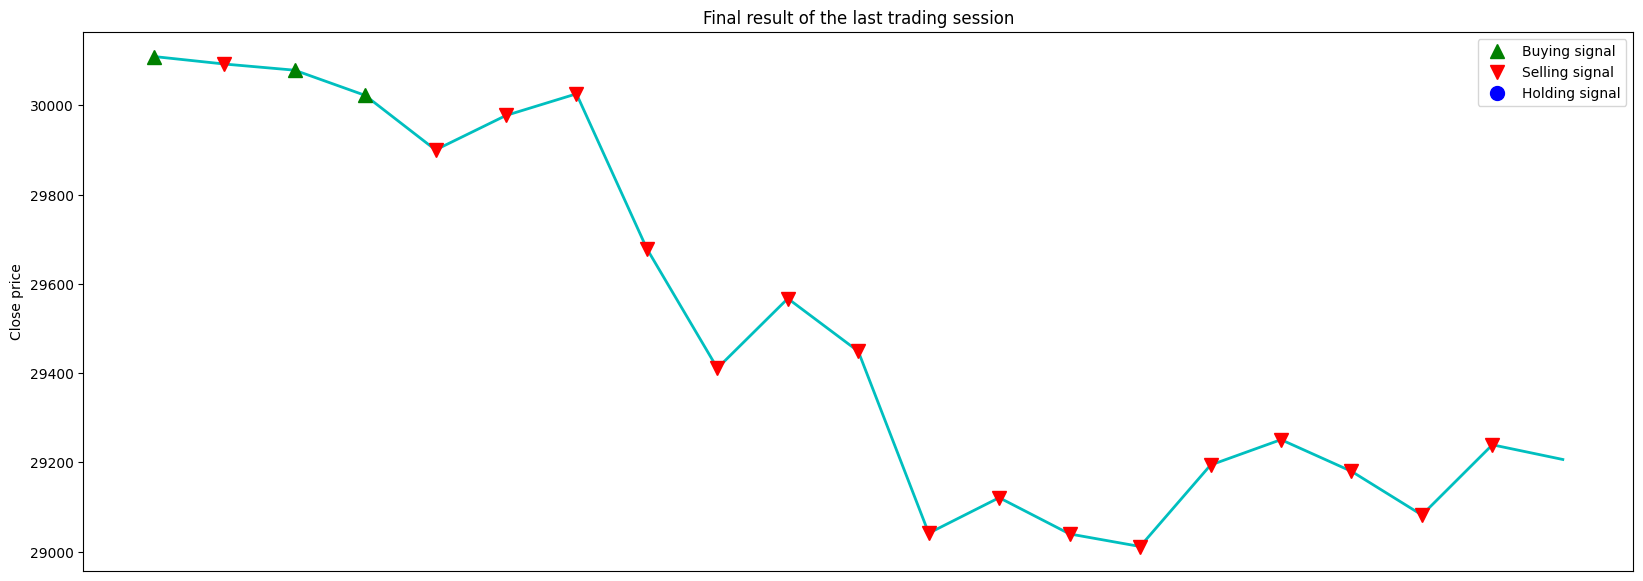

episode - 1 || score - 0.04865487563519075


In [61]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action, lstm_cells = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
        print(round(reward,6))
    env.final_render()
    print(f'episode - {n} || score - {score}')